In [1]:
import pandas as pd

final_dataset = pd.read_csv('mp1.csv')
test_dataset = pd.read_csv('m1_test.csv')
print(final_dataset)

        Store  Container_404  Bad_Subs  Manual_Pick
0       53223             63        27           82
1       24612             33        47          115
2       40717             69         5           61
3       77993             74        20          171
4       99213             27        28            1
...       ...            ...       ...          ...
119971  26396             36        25           17
119972  59132             75        19           32
119973  94912              4        16          186
119974  85080             57        28           23
119975  60365             19        28          136

[119976 rows x 4 columns]


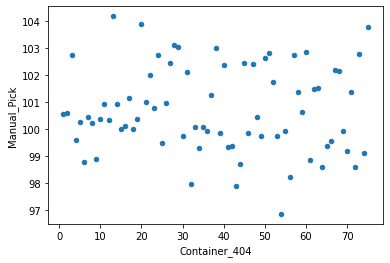

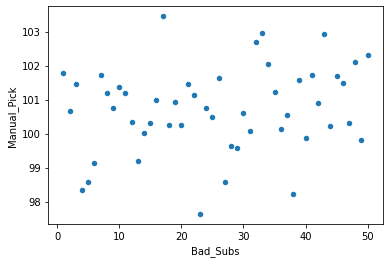

In [2]:
import matplotlib.pyplot as plt

plot_df = final_dataset[['Manual_Pick', 'Container_404']]
rounded_temp = plot_df['Container_404'].round(0)  # nearest integer
plot_df = plot_df.groupby(rounded_temp).mean()
plot_df.plot.scatter(x='Container_404', y='Manual_Pick')
plt.show()

plot_df = final_dataset[['Manual_Pick', 'Bad_Subs']]
rounded_temp = plot_df['Bad_Subs'].round(0)  # nearest integer
plot_df = plot_df.groupby(rounded_temp).mean()
plot_df.plot.scatter(x='Bad_Subs', y='Manual_Pick')
plt.show()

In [ ]:
def split_train_eval(final_dataset):
    final_dataset = final_dataset.sample(frac=1)
    eval_size = len(final_dataset) // 10
    eval_set = final_dataset.iloc[:eval_size]
    train_set = final_dataset.iloc[eval_size:]
    return train_set, eval_set

def add_int_features(dataset_row, feature_dict, has_labels):
    int_vals = ['Store','Container_404','Bad_Subs']
    if has_labels:
        int_vals.append('Manual_Pick')
    for feature_name in int_vals:
        list_val = tf.train.Int64List(value=[dataset_row[feature_name]])
        feature_dict[feature_name] = tf.train.Feature(int64_list=list_val)

def create_example(dataset_row, has_labels):
    feature_dict = {}
    add_int_features(dataset_row, feature_dict, True)
    features_obj = tf.train.Features(feature=feature_dict)
    return tf.train.Example(features=features_obj)

In [ ]:
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

# Write serialized Example objects to a TFRecords file
def write_tfrecords(dataset, has_labels, tfrecords_file):
    writer = tf.compat.v1.python_io.TFRecordWriter(tfrecords_file)
    for i in range(len(dataset)):
        example = create_example(dataset.iloc[i], has_labels)
        writer.write(example.SerializeToString())
    writer.close()



# train_set is the training DataFrame
write_tfrecords(split_train_eval(final_dataset)[0], True, 'train_manual_pick.tfrecords')

# eval_set is the evaluation DataFrame
write_tfrecords(split_train_eval(final_dataset)[1], True, 'eval_manual_pick.tfrecords')

# test_set is the test DataFrame
write_tfrecords(test_dataset, False, 'test_manual_pick.tfrecords')

In [ ]:
import tensorflow as tf

# Create the spec used when parsing the Example object
def create_example_spec(has_labels):
    example_spec = {}
    int_vals = ['Store','Container_404','Bad_Subs']
    if has_labels:
        int_vals.append('Manual_Pick')
    for feature_name in int_vals:
        example_spec[feature_name] = tf.compat.v1.FixedLenFeature((), tf.int64)
    return example_spec

example_spec = create_example_spec(True)

# Helper function to convert serialized Example objects into features
def parse_features(ser_ex, example_spec, has_labels):
    parsed_features = tf.compat.v1.parse_single_example(ser_ex, example_spec)
    features = {k: parsed_features[k] for k in parsed_features if k != 'Manual_Pick'}
    if not has_labels:
        return features
    label = parsed_features['Manual_Pick']
    return features,label

def get_train_data():
    train_file = 'train_manual_pick.tfrecords'
    train_dataset = tf.data.TFRecordDataset(train_file)
    parse_fn = lambda ser_ex: parse_features(ser_ex, example_spec, True)
    train_dataset = train_dataset.map(parse_fn)
    train_dataset = train_dataset.shuffle(100000)
    train_dataset = train_dataset.batch(1000)
    return train_dataset

def get_eval_data():
    eval_file = 'eval_manual_pick.tfrecords'
    eval_dataset = tf.data.TFRecordDataset(eval_file)
    parse_fn = lambda ser_ex: parse_features(ser_ex, example_spec, True)
    eval_dataset = eval_dataset.map(parse_fn)
    eval_dataset = eval_dataset.shuffle(100000)
    eval_dataset = eval_dataset.batch(200)
    return eval_dataset

def get_test_data():
    test_file = 'test_manual_pick.tfrecords'
    test_dataset = tf.data.TFRecordDataset(eval_file)
    parse_fn = lambda ser_ex: parse_features(ser_ex, example_spec, True)
    test_dataset = test_dataset.map(parse_fn)
    return test_dataset

In [ ]:
import tensorflow as tf

def add_numeric_columns(feature_columns):
    numeric_features = ['Store','Container_404','Bad_Subs']
    for feature_name in numeric_features:
        feature_col = tf.feature_column.numeric_column(feature_name, shape=())
        feature_columns.append(feature_col)

def create_feature_columns():
    feature_columns = []
    add_numeric_columns(feature_columns)
    return feature_columns


In [ ]:
class SubsModel(object):
  def __init__(self, hidden_layers):
    self.hidden_layers = hidden_layers
  
  def run_regression_predict(self, ckpt_dir, data_file):
    regression_model = self.create_regression_model(ckpt_dir)
    predictions = regression_model.predict(input_fn=get_test_data)
    print("Predictions ",predictions)
    pred_list = []
    for pred_dict in predictions:
        pred_list.append(pred_dict['predictions'][0])
    print(pred_list)
    return pred_list

  def run_regression_eval(self, ckpt_dir):
    regression_model = self.create_regression_model(ckpt_dir)
    return regression_model.evaluate(input_fn=get_eval_data)

  def run_regression_training(self, ckpt_dir, batch_size, num_training_steps=None):
    regression_model = self.create_regression_model(ckpt_dir)
    regression_model.train(input_fn=get_train_data, steps=num_training_steps)

  def create_regression_model(self, ckpt_dir):
    config = tf.estimator.RunConfig(log_step_count_steps=5000)
    regression_model = tf.estimator.Estimator(
      self.regression_fn,
      config=config,
      model_dir=ckpt_dir)
    return regression_model

  def regression_fn(self, features, labels, mode, params):
    feature_columns = create_feature_columns()
    inputs = tf.compat.v1.feature_column.input_layer(features, feature_columns)
    batch_predictions = self.model_layers(inputs) 
    predictions = tf.squeeze(batch_predictions)
    if labels is not None:
        loss = tf.compat.v1.losses.absolute_difference(labels, predictions)
        
    if mode == tf.estimator.ModeKeys.TRAIN:
        global_step = tf.compat.v1.train.get_or_create_global_step()
        adam = tf.compat.v1.train.AdamOptimizer()
        train_op = adam.minimize(
        loss, global_step=global_step)
        return tf.estimator.EstimatorSpec(mode, loss=loss, train_op=train_op)
    if mode == tf.estimator.ModeKeys.EVAL:
        return tf.estimator.EstimatorSpec(mode, loss=loss)
    if mode == tf.estimator.ModeKeys.PREDICT:
        prediction_info = {
          'predictions': batch_predictions
        }
    return tf.estimator.EstimatorSpec(mode, predictions=prediction_info)

  def model_layers(self, inputs):
    layer = inputs
    for num_nodes in self.hidden_layers:
        layer = tf.compat.v1.layers.dense(layer, num_nodes,
        activation=tf.nn.relu)
    batch_predictions = tf.compat.v1.layers.dense(layer, 1)
    return batch_predictions

In [ ]:
subs_model = SubsModel([200,100])
count = 100000
for i in range(count):
    subs_model.run_regression_training(ckpt_dir="/tmp/test_manual_pick", batch_size=500)
subs_model.run_regression_eval(ckpt_dir="/tmp/test_manual_pick")
#subs_model.run_regression_predict(ckpt_dir="/tmp/test_manual_pick", data_file="train_manual_pick.tfrecords")
print("Done")

INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts

INFO:tensorflow:loss = 53.44001, step = 15561
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 15669...
INFO:tensorflow:Saving checkpoints for 15669 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 15669...
INFO:tensorflow:Loss for final step: 53.80113.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSp

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/test_manual_pick/model.ckpt-16101
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 16101...
INFO:tensorflow:Saving checkpoints for 16101 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 16101...
INFO:tensorflow:loss = 59.038578, step = 16101
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 16209...
INFO:tensorflow:Saving checkpoints for 16209 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 16209...
INFO:tensorflow:Loss for final step: 53.046787.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_sum

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 16533...
INFO:tensorflow:Saving checkpoints for 16533 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 16533...
INFO:tensorflow:loss = 58.27404, step = 16533
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 16641...
INFO:tensorflow:Saving checkpoints for 16641 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 16641...
INFO:tensorflow:Loss for final step: 53.006817.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_

INFO:tensorflow:Saving checkpoints for 17073 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 17073...
INFO:tensorflow:Loss for final step: 54.092834.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chi

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/test_manual_pick/model.ckpt-17505
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 17505...
INFO:tensorflow:Saving checkpoints for 17505 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 17505...
INFO:tensorflow:loss = 52.167374, step = 17505
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 17613...
INFO:tensorflow:Saving checkpoints for 17613 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 17613...
INFO:tensorflow:Loss for final step: 51.9664.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summa

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 17937...
INFO:tensorflow:Saving checkpoints for 17937 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 17937...
INFO:tensorflow:loss = 50.359383, step = 17937
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 18045...
INFO:tensorflow:Saving checkpoints for 18045 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 18045...
INFO:tensorflow:Loss for final step: 52.168247.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '

INFO:tensorflow:Saving checkpoints for 18477 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 18477...
INFO:tensorflow:Loss for final step: 54.087307.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chi

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/test_manual_pick/model.ckpt-18909
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 18909...
INFO:tensorflow:Saving checkpoints for 18909 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 18909...
INFO:tensorflow:loss = 53.966953, step = 18909
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 19017...
INFO:tensorflow:Saving checkpoints for 19017 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 19017...
INFO:tensorflow:Loss for final step: 54.137207.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_sum

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 19341...
INFO:tensorflow:Saving checkpoints for 19341 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 19341...
INFO:tensorflow:loss = 51.793858, step = 19341
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 19449...
INFO:tensorflow:Saving checkpoints for 19449 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 19449...
INFO:tensorflow:Loss for final step: 52.013935.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '

INFO:tensorflow:Saving checkpoints for 19881 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 19881...
INFO:tensorflow:Loss for final step: 51.53694.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chie

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/test_manual_pick/model.ckpt-20313
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 20313...
INFO:tensorflow:Saving checkpoints for 20313 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 20313...
INFO:tensorflow:loss = 52.63268, step = 20313
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 20421...
INFO:tensorflow:Saving checkpoints for 20421 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 20421...
INFO:tensorflow:Loss for final step: 53.05622.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summa

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 20745...
INFO:tensorflow:Saving checkpoints for 20745 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 20745...
INFO:tensorflow:loss = 51.55494, step = 20745
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 20853...
INFO:tensorflow:Saving checkpoints for 20853 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 20853...
INFO:tensorflow:Loss for final step: 52.999565.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_

INFO:tensorflow:Saving checkpoints for 21285 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 21285...
INFO:tensorflow:Loss for final step: 54.737858.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chi

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/test_manual_pick/model.ckpt-21717
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 21717...
INFO:tensorflow:Saving checkpoints for 21717 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 21717...
INFO:tensorflow:loss = 53.765873, step = 21717
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 21825...
INFO:tensorflow:Saving checkpoints for 21825 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 21825...
INFO:tensorflow:Loss for final step: 54.1422.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summa

INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 22149...
INFO:tensorflow:Saving checkpoints for 22149 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 22149...
INFO:tensorflow:loss = 52.739895, step = 22149
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 22257...
INFO:tensorflow:Saving checkpoints for 22257 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 22257...
INFO:tensorflow:Loss for final step: 55.326256.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000,

INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 22689...
INFO:tensorflow:Loss for final step: 51.628242.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/test_manual_pick/model.ckpt-23121
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 23121...
INFO:tensorflow:Saving checkpoints for 23121 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 23121...
INFO:tensorflow:loss = 51.63032, step = 23121
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 23229...
INFO:tensorflow:Saving checkpoints for 23229 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 23229...
INFO:tensorflow:Loss for final step: 52.089764.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summ

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 23553...
INFO:tensorflow:Saving checkpoints for 23553 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 23553...
INFO:tensorflow:loss = 52.993233, step = 23553
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 23661...
INFO:tensorflow:Saving checkpoints for 23661 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 23661...
INFO:tensorflow:Loss for final step: 52.650196.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '

INFO:tensorflow:Saving checkpoints for 24093 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 24093...
INFO:tensorflow:Loss for final step: 51.227497.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chi

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/test_manual_pick/model.ckpt-24525
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 24525...
INFO:tensorflow:Saving checkpoints for 24525 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 24525...
INFO:tensorflow:loss = 53.499664, step = 24525
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 24633...
INFO:tensorflow:Saving checkpoints for 24633 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 24633...
INFO:tensorflow:Loss for final step: 51.95451.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summ

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 24957...
INFO:tensorflow:Saving checkpoints for 24957 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 24957...
INFO:tensorflow:loss = 51.883785, step = 24957
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 25065...
INFO:tensorflow:Saving checkpoints for 25065 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 25065...
INFO:tensorflow:Loss for final step: 50.75818.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_

INFO:tensorflow:Saving checkpoints for 25497 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 25497...
INFO:tensorflow:Loss for final step: 51.43447.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chie

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/test_manual_pick/model.ckpt-25929
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 25929...
INFO:tensorflow:Saving checkpoints for 25929 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 25929...
INFO:tensorflow:loss = 51.427147, step = 25929
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 26037...
INFO:tensorflow:Saving checkpoints for 26037 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 26037...
INFO:tensorflow:Loss for final step: 51.947826.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_sum

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 26361...
INFO:tensorflow:Saving checkpoints for 26361 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 26361...
INFO:tensorflow:loss = 51.535515, step = 26361
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 26469...
INFO:tensorflow:Saving checkpoints for 26469 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 26469...
INFO:tensorflow:Loss for final step: 51.758953.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '

INFO:tensorflow:Saving checkpoints for 26901 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 26901...
INFO:tensorflow:Loss for final step: 51.905254.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chi

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/test_manual_pick/model.ckpt-27333
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 27333...
INFO:tensorflow:Saving checkpoints for 27333 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 27333...
INFO:tensorflow:loss = 51.139553, step = 27333
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 27441...
INFO:tensorflow:Saving checkpoints for 27441 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 27441...
INFO:tensorflow:Loss for final step: 50.109615.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_sum

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 27765...
INFO:tensorflow:Saving checkpoints for 27765 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 27765...
INFO:tensorflow:loss = 51.60746, step = 27765
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 27873...
INFO:tensorflow:Saving checkpoints for 27873 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 27873...
INFO:tensorflow:Loss for final step: 52.210213.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_

INFO:tensorflow:Saving checkpoints for 28305 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 28305...
INFO:tensorflow:Loss for final step: 51.461132.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chi

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/test_manual_pick/model.ckpt-28737
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 28737...
INFO:tensorflow:Saving checkpoints for 28737 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 28737...
INFO:tensorflow:loss = 51.60682, step = 28737
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 28845...
INFO:tensorflow:Saving checkpoints for 28845 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 28845...
INFO:tensorflow:Loss for final step: 54.776333.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summ

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 29169...
INFO:tensorflow:Saving checkpoints for 29169 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 29169...
INFO:tensorflow:loss = 53.13267, step = 29169
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 29277...
INFO:tensorflow:Saving checkpoints for 29277 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 29277...
INFO:tensorflow:Loss for final step: 53.13588.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_k

INFO:tensorflow:Saving checkpoints for 29709 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 29709...
INFO:tensorflow:Loss for final step: 54.070927.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chi

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/test_manual_pick/model.ckpt-30141
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 30141...
INFO:tensorflow:Saving checkpoints for 30141 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 30141...
INFO:tensorflow:loss = 51.88572, step = 30141
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 30249...
INFO:tensorflow:Saving checkpoints for 30249 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 30249...
INFO:tensorflow:Loss for final step: 54.98446.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summa

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 30573...
INFO:tensorflow:Saving checkpoints for 30573 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 30573...
INFO:tensorflow:loss = 52.547413, step = 30573
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 30681...
INFO:tensorflow:Saving checkpoints for 30681 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 30681...
INFO:tensorflow:Loss for final step: 53.665783.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '

INFO:tensorflow:Saving checkpoints for 31113 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 31113...
INFO:tensorflow:Loss for final step: 52.606472.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chi

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/test_manual_pick/model.ckpt-31545
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 31545...
INFO:tensorflow:Saving checkpoints for 31545 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 31545...
INFO:tensorflow:loss = 52.349697, step = 31545
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 31653...
INFO:tensorflow:Saving checkpoints for 31653 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 31653...
INFO:tensorflow:Loss for final step: 53.473614.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_sum

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 31977...
INFO:tensorflow:Saving checkpoints for 31977 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 31977...
INFO:tensorflow:loss = 49.274197, step = 31977
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 32085...
INFO:tensorflow:Saving checkpoints for 32085 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 32085...
INFO:tensorflow:Loss for final step: 52.387764.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '

INFO:tensorflow:Saving checkpoints for 32517 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 32517...
INFO:tensorflow:Loss for final step: 52.416565.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chi

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/test_manual_pick/model.ckpt-32949
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 32949...
INFO:tensorflow:Saving checkpoints for 32949 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 32949...
INFO:tensorflow:loss = 49.97814, step = 32949
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 33057...
INFO:tensorflow:Saving checkpoints for 33057 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 33057...
INFO:tensorflow:Loss for final step: 54.03518.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summa

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 33381...
INFO:tensorflow:Saving checkpoints for 33381 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 33381...
INFO:tensorflow:loss = 53.06101, step = 33381
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 33489...
INFO:tensorflow:Saving checkpoints for 33489 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 33489...
INFO:tensorflow:Loss for final step: 50.060833.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_

INFO:tensorflow:Saving checkpoints for 33921 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 33921...
INFO:tensorflow:Loss for final step: 50.110245.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chi

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/test_manual_pick/model.ckpt-34353
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 34353...
INFO:tensorflow:Saving checkpoints for 34353 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 34353...
INFO:tensorflow:loss = 51.448505, step = 34353
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 34461...
INFO:tensorflow:Saving checkpoints for 34461 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 34461...
INFO:tensorflow:Loss for final step: 51.393776.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_sum

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 34785...
INFO:tensorflow:Saving checkpoints for 34785 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 34785...
INFO:tensorflow:loss = 52.644882, step = 34785
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 34893...
INFO:tensorflow:Saving checkpoints for 34893 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 34893...
INFO:tensorflow:Loss for final step: 51.663395.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '

INFO:tensorflow:Saving checkpoints for 35325 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 35325...
INFO:tensorflow:Loss for final step: 52.821873.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chi

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/test_manual_pick/model.ckpt-35757
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 35757...
INFO:tensorflow:Saving checkpoints for 35757 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 35757...
INFO:tensorflow:loss = 51.74046, step = 35757
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 35865...
INFO:tensorflow:Saving checkpoints for 35865 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 35865...
INFO:tensorflow:Loss for final step: 53.465187.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summ

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 36189...
INFO:tensorflow:Saving checkpoints for 36189 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 36189...
INFO:tensorflow:loss = 51.70619, step = 36189
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 36297...
INFO:tensorflow:Saving checkpoints for 36297 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 36297...
INFO:tensorflow:Loss for final step: 54.75243.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_k

INFO:tensorflow:Saving checkpoints for 36729 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 36729...
INFO:tensorflow:Loss for final step: 54.132656.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chi

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/test_manual_pick/model.ckpt-37161
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 37161...
INFO:tensorflow:Saving checkpoints for 37161 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 37161...
INFO:tensorflow:loss = 49.34361, step = 37161
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 37269...
INFO:tensorflow:Saving checkpoints for 37269 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 37269...
INFO:tensorflow:Loss for final step: 54.056965.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summ

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 37593...
INFO:tensorflow:Saving checkpoints for 37593 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 37593...
INFO:tensorflow:loss = 51.64568, step = 37593
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 37701...
INFO:tensorflow:Saving checkpoints for 37701 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 37701...
INFO:tensorflow:Loss for final step: 51.53623.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_k

INFO:tensorflow:Saving checkpoints for 38133 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 38133...
INFO:tensorflow:Loss for final step: 52.118893.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chi

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/test_manual_pick/model.ckpt-38565
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 38565...
INFO:tensorflow:Saving checkpoints for 38565 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 38565...
INFO:tensorflow:loss = 52.209164, step = 38565
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 38673...
INFO:tensorflow:Saving checkpoints for 38673 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 38673...
INFO:tensorflow:Loss for final step: 53.07915.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summ

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 38997...
INFO:tensorflow:Saving checkpoints for 38997 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 38997...
INFO:tensorflow:loss = 55.16921, step = 38997
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 39105...
INFO:tensorflow:Saving checkpoints for 39105 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 39105...
INFO:tensorflow:Loss for final step: 51.761456.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_

INFO:tensorflow:Saving checkpoints for 39537 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 39537...
INFO:tensorflow:Loss for final step: 54.198994.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chi

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/test_manual_pick/model.ckpt-39969
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 39969...
INFO:tensorflow:Saving checkpoints for 39969 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 39969...
INFO:tensorflow:loss = 50.67011, step = 39969
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 40077...
INFO:tensorflow:Saving checkpoints for 40077 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 40077...
INFO:tensorflow:Loss for final step: 52.58114.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summa

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 40401...
INFO:tensorflow:Saving checkpoints for 40401 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 40401...
INFO:tensorflow:loss = 51.941772, step = 40401
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 40509...
INFO:tensorflow:Saving checkpoints for 40509 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 40509...
INFO:tensorflow:Loss for final step: 51.266804.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '

INFO:tensorflow:Saving checkpoints for 40941 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 40941...
INFO:tensorflow:Loss for final step: 48.80775.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chie

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/test_manual_pick/model.ckpt-41373
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 41373...
INFO:tensorflow:Saving checkpoints for 41373 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 41373...
INFO:tensorflow:loss = 51.883186, step = 41373
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 41481...
INFO:tensorflow:Saving checkpoints for 41481 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 41481...
INFO:tensorflow:Loss for final step: 50.572002.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_sum

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 41805...
INFO:tensorflow:Saving checkpoints for 41805 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 41805...
INFO:tensorflow:loss = 52.707493, step = 41805
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 41913...
INFO:tensorflow:Saving checkpoints for 41913 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 41913...
INFO:tensorflow:Loss for final step: 49.8986.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_k

INFO:tensorflow:Saving checkpoints for 42345 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 42345...
INFO:tensorflow:Loss for final step: 50.253223.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chi

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/test_manual_pick/model.ckpt-42777
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 42777...
INFO:tensorflow:Saving checkpoints for 42777 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 42777...
INFO:tensorflow:loss = 50.718643, step = 42777
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 42885...
INFO:tensorflow:Saving checkpoints for 42885 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 42885...
INFO:tensorflow:Loss for final step: 50.60242.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summ

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 43209...
INFO:tensorflow:Saving checkpoints for 43209 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 43209...
INFO:tensorflow:loss = 50.8449, step = 43209
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 43317...
INFO:tensorflow:Saving checkpoints for 43317 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 43317...
INFO:tensorflow:Loss for final step: 50.608208.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_k

INFO:tensorflow:Saving checkpoints for 43749 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 43749...
INFO:tensorflow:Loss for final step: 51.472675.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chi

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/test_manual_pick/model.ckpt-44181
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 44181...
INFO:tensorflow:Saving checkpoints for 44181 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 44181...
INFO:tensorflow:loss = 51.378147, step = 44181
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 44289...
INFO:tensorflow:Saving checkpoints for 44289 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 44289...
INFO:tensorflow:Loss for final step: 51.785954.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_sum

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 44613...
INFO:tensorflow:Saving checkpoints for 44613 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 44613...
INFO:tensorflow:loss = 51.715706, step = 44613
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 44721...
INFO:tensorflow:Saving checkpoints for 44721 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 44721...
INFO:tensorflow:Loss for final step: 50.481785.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '

INFO:tensorflow:Saving checkpoints for 45153 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 45153...
INFO:tensorflow:Loss for final step: 51.195602.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chi

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/test_manual_pick/model.ckpt-45585
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 45585...
INFO:tensorflow:Saving checkpoints for 45585 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 45585...
INFO:tensorflow:loss = 48.677616, step = 45585
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 45693...
INFO:tensorflow:Saving checkpoints for 45693 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 45693...
INFO:tensorflow:Loss for final step: 51.89985.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summ

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 46017...
INFO:tensorflow:Saving checkpoints for 46017 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 46017...
INFO:tensorflow:loss = 51.939705, step = 46017
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 46125...
INFO:tensorflow:Saving checkpoints for 46125 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 46125...
INFO:tensorflow:Loss for final step: 53.204082.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '

INFO:tensorflow:Saving checkpoints for 46557 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 46557...
INFO:tensorflow:Loss for final step: 51.989895.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chi

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/test_manual_pick/model.ckpt-46989
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 46989...
INFO:tensorflow:Saving checkpoints for 46989 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 46989...
INFO:tensorflow:loss = 53.094265, step = 46989
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 47097...
INFO:tensorflow:Saving checkpoints for 47097 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 47097...
INFO:tensorflow:Loss for final step: 52.757504.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_sum

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 47421...
INFO:tensorflow:Saving checkpoints for 47421 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 47421...
INFO:tensorflow:loss = 49.94745, step = 47421
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 47529...
INFO:tensorflow:Saving checkpoints for 47529 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 47529...
INFO:tensorflow:Loss for final step: 50.039124.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_

INFO:tensorflow:Saving checkpoints for 47961 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 47961...
INFO:tensorflow:Loss for final step: 51.476063.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chi

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/test_manual_pick/model.ckpt-48393
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 48393...
INFO:tensorflow:Saving checkpoints for 48393 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 48393...
INFO:tensorflow:loss = 50.993702, step = 48393
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 48501...
INFO:tensorflow:Saving checkpoints for 48501 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 48501...
INFO:tensorflow:Loss for final step: 50.53545.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summ

INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 48825...
INFO:tensorflow:Saving checkpoints for 48825 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 48825...
INFO:tensorflow:loss = 51.387062, step = 48825
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 48933...
INFO:tensorflow:Saving checkpoints for 48933 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 48933...
INFO:tensorflow:Loss for final step: 51.49503.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, 

INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 49365...
INFO:tensorflow:Loss for final step: 52.001682.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/test_manual_pick/model.ckpt-49797
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 49797...
INFO:tensorflow:Saving checkpoints for 49797 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 49797...
INFO:tensorflow:loss = 51.579285, step = 49797
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 49905...
INFO:tensorflow:Saving checkpoints for 49905 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 49905...
INFO:tensorflow:Loss for final step: 51.416176.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_sum

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 50229...
INFO:tensorflow:Saving checkpoints for 50229 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 50229...
INFO:tensorflow:loss = 55.197536, step = 50229
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 50337...
INFO:tensorflow:Saving checkpoints for 50337 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 50337...
INFO:tensorflow:Loss for final step: 51.359848.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '

INFO:tensorflow:Saving checkpoints for 50769 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 50769...
INFO:tensorflow:Loss for final step: 48.196236.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chi

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/test_manual_pick/model.ckpt-51201
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 51201...
INFO:tensorflow:Saving checkpoints for 51201 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 51201...
INFO:tensorflow:loss = 50.515415, step = 51201
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 51309...
INFO:tensorflow:Saving checkpoints for 51309 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 51309...
INFO:tensorflow:Loss for final step: 50.54352.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summ

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 51633...
INFO:tensorflow:Saving checkpoints for 51633 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 51633...
INFO:tensorflow:loss = 50.058594, step = 51633
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 51741...
INFO:tensorflow:Saving checkpoints for 51741 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 51741...
INFO:tensorflow:Loss for final step: 50.481823.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '

INFO:tensorflow:Saving checkpoints for 52173 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 52173...
INFO:tensorflow:Loss for final step: 51.69716.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chie

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/test_manual_pick/model.ckpt-52605
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 52605...
INFO:tensorflow:Saving checkpoints for 52605 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 52605...
INFO:tensorflow:loss = 53.530334, step = 52605
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 52713...
INFO:tensorflow:Saving checkpoints for 52713 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 52713...
INFO:tensorflow:Loss for final step: 51.934643.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_sum

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 53037...
INFO:tensorflow:Saving checkpoints for 53037 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 53037...
INFO:tensorflow:loss = 50.48222, step = 53037
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 53145...
INFO:tensorflow:Saving checkpoints for 53145 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 53145...
INFO:tensorflow:Loss for final step: 50.822895.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_

INFO:tensorflow:Saving checkpoints for 53577 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 53577...
INFO:tensorflow:Loss for final step: 49.023544.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chi

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/test_manual_pick/model.ckpt-54009
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 54009...
INFO:tensorflow:Saving checkpoints for 54009 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 54009...
INFO:tensorflow:loss = 48.550297, step = 54009
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 54117...
INFO:tensorflow:Saving checkpoints for 54117 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 54117...
INFO:tensorflow:Loss for final step: 51.56916.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summ

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 54441...
INFO:tensorflow:Saving checkpoints for 54441 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 54441...
INFO:tensorflow:loss = 50.71793, step = 54441
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 54549...
INFO:tensorflow:Saving checkpoints for 54549 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 54549...
INFO:tensorflow:Loss for final step: 51.452026.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_

INFO:tensorflow:Saving checkpoints for 54981 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 54981...
INFO:tensorflow:Loss for final step: 52.607807.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chi

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/test_manual_pick/model.ckpt-55413
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 55413...
INFO:tensorflow:Saving checkpoints for 55413 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 55413...
INFO:tensorflow:loss = 49.94293, step = 55413
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 55521...
INFO:tensorflow:Saving checkpoints for 55521 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 55521...
INFO:tensorflow:Loss for final step: 49.8513.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summar

INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 55845...
INFO:tensorflow:Saving checkpoints for 55845 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 55845...
INFO:tensorflow:loss = 50.44839, step = 55845
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 55953...
INFO:tensorflow:Saving checkpoints for 55953 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 55953...
INFO:tensorflow:Loss for final step: 52.433743.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, 

INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 56385...
INFO:tensorflow:Loss for final step: 52.226143.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/test_manual_pick/model.ckpt-56817
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 56817...
INFO:tensorflow:Saving checkpoints for 56817 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 56817...
INFO:tensorflow:loss = 49.793903, step = 56817
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 56925...
INFO:tensorflow:Saving checkpoints for 56925 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 56925...
INFO:tensorflow:Loss for final step: 51.859703.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_sum

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 57249...
INFO:tensorflow:Saving checkpoints for 57249 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 57249...
INFO:tensorflow:loss = 50.19476, step = 57249
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 57357...
INFO:tensorflow:Saving checkpoints for 57357 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 57357...
INFO:tensorflow:Loss for final step: 47.847656.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_

INFO:tensorflow:Saving checkpoints for 57789 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 57789...
INFO:tensorflow:Loss for final step: 50.69668.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chie

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/test_manual_pick/model.ckpt-58221
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 58221...
INFO:tensorflow:Saving checkpoints for 58221 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 58221...
INFO:tensorflow:loss = 52.92718, step = 58221
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 58329...
INFO:tensorflow:Saving checkpoints for 58329 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 58329...
INFO:tensorflow:Loss for final step: 50.514225.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summ

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 58653...
INFO:tensorflow:Saving checkpoints for 58653 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 58653...
INFO:tensorflow:loss = 59.553806, step = 58653
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 58761...
INFO:tensorflow:Saving checkpoints for 58761 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 58761...
INFO:tensorflow:Loss for final step: 50.3409.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_k

INFO:tensorflow:Saving checkpoints for 59193 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 59193...
INFO:tensorflow:Loss for final step: 50.795757.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chi

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/test_manual_pick/model.ckpt-59625
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 59625...
INFO:tensorflow:Saving checkpoints for 59625 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 59625...
INFO:tensorflow:loss = 51.026157, step = 59625
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 59733...
INFO:tensorflow:Saving checkpoints for 59733 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 59733...
INFO:tensorflow:Loss for final step: 48.976166.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_sum

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 60057...
INFO:tensorflow:Saving checkpoints for 60057 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 60057...
INFO:tensorflow:loss = 49.330067, step = 60057
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 60165...
INFO:tensorflow:Saving checkpoints for 60165 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 60165...
INFO:tensorflow:Loss for final step: 49.789703.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '

INFO:tensorflow:Saving checkpoints for 60597 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 60597...
INFO:tensorflow:Loss for final step: 50.63858.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chie

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/test_manual_pick/model.ckpt-61029
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 61029...
INFO:tensorflow:Saving checkpoints for 61029 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 61029...
INFO:tensorflow:loss = 50.058575, step = 61029
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 61137...
INFO:tensorflow:Saving checkpoints for 61137 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 61137...
INFO:tensorflow:Loss for final step: 52.22928.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summ

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 61461...
INFO:tensorflow:Saving checkpoints for 61461 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 61461...
INFO:tensorflow:loss = 51.096798, step = 61461
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 61569...
INFO:tensorflow:Saving checkpoints for 61569 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 61569...
INFO:tensorflow:Loss for final step: 50.327496.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '

INFO:tensorflow:Saving checkpoints for 62001 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 62001...
INFO:tensorflow:Loss for final step: 51.60901.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chie

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/test_manual_pick/model.ckpt-62433
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 62433...
INFO:tensorflow:Saving checkpoints for 62433 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 62433...
INFO:tensorflow:loss = 50.072914, step = 62433
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 62541...
INFO:tensorflow:Saving checkpoints for 62541 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 62541...
INFO:tensorflow:Loss for final step: 49.674126.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_sum

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 62865...
INFO:tensorflow:Saving checkpoints for 62865 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 62865...
INFO:tensorflow:loss = 49.904587, step = 62865
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 62973...
INFO:tensorflow:Saving checkpoints for 62973 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 62973...
INFO:tensorflow:Loss for final step: 51.977272.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '

INFO:tensorflow:Saving checkpoints for 63405 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 63405...
INFO:tensorflow:Loss for final step: 50.714104.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chi

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/test_manual_pick/model.ckpt-63837
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 63837...
INFO:tensorflow:Saving checkpoints for 63837 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 63837...
INFO:tensorflow:loss = 50.510338, step = 63837
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 63945...
INFO:tensorflow:Saving checkpoints for 63945 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 63945...
INFO:tensorflow:Loss for final step: 49.356613.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_sum

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 64269...
INFO:tensorflow:Saving checkpoints for 64269 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 64269...
INFO:tensorflow:loss = 49.507946, step = 64269
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 64377...
INFO:tensorflow:Saving checkpoints for 64377 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 64377...
INFO:tensorflow:Loss for final step: 51.455196.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '

INFO:tensorflow:Saving checkpoints for 64809 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 64809...
INFO:tensorflow:Loss for final step: 50.051193.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chi

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/test_manual_pick/model.ckpt-65241
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 65241...
INFO:tensorflow:Saving checkpoints for 65241 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 65241...
INFO:tensorflow:loss = 49.586166, step = 65241
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 65349...
INFO:tensorflow:Saving checkpoints for 65349 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 65349...
INFO:tensorflow:Loss for final step: 50.40908.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summ

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 65673...
INFO:tensorflow:Saving checkpoints for 65673 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 65673...
INFO:tensorflow:loss = 50.450123, step = 65673
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 65781...
INFO:tensorflow:Saving checkpoints for 65781 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 65781...
INFO:tensorflow:Loss for final step: 49.520405.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '

INFO:tensorflow:Saving checkpoints for 66213 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 66213...
INFO:tensorflow:Loss for final step: 50.411823.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chi

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/test_manual_pick/model.ckpt-66645
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 66645...
INFO:tensorflow:Saving checkpoints for 66645 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 66645...
INFO:tensorflow:loss = 51.295826, step = 66645
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 66753...
INFO:tensorflow:Saving checkpoints for 66753 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 66753...
INFO:tensorflow:Loss for final step: 50.494743.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_sum

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 67077...
INFO:tensorflow:Saving checkpoints for 67077 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 67077...
INFO:tensorflow:loss = 50.8085, step = 67077
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 67185...
INFO:tensorflow:Saving checkpoints for 67185 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 67185...
INFO:tensorflow:Loss for final step: 47.63538.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_ke

INFO:tensorflow:Saving checkpoints for 67617 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 67617...
INFO:tensorflow:Loss for final step: 51.042206.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chi

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/test_manual_pick/model.ckpt-68049
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 68049...
INFO:tensorflow:Saving checkpoints for 68049 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 68049...
INFO:tensorflow:loss = 49.468967, step = 68049
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 68157...
INFO:tensorflow:Saving checkpoints for 68157 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 68157...
INFO:tensorflow:Loss for final step: 50.597363.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_sum

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 68481...
INFO:tensorflow:Saving checkpoints for 68481 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 68481...
INFO:tensorflow:loss = 50.321175, step = 68481
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 68589...
INFO:tensorflow:Saving checkpoints for 68589 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 68589...
INFO:tensorflow:Loss for final step: 51.409492.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '

INFO:tensorflow:Saving checkpoints for 69021 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 69021...
INFO:tensorflow:Loss for final step: 50.30868.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chie

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/test_manual_pick/model.ckpt-69453
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 69453...
INFO:tensorflow:Saving checkpoints for 69453 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 69453...
INFO:tensorflow:loss = 50.89875, step = 69453
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 69561...
INFO:tensorflow:Saving checkpoints for 69561 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 69561...
INFO:tensorflow:Loss for final step: 49.841442.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summ

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 69885...
INFO:tensorflow:Saving checkpoints for 69885 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 69885...
INFO:tensorflow:loss = 49.79202, step = 69885
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 69993...
INFO:tensorflow:Saving checkpoints for 69993 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 69993...
INFO:tensorflow:Loss for final step: 50.72664.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_k

INFO:tensorflow:Saving checkpoints for 70425 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 70425...
INFO:tensorflow:Loss for final step: 49.142715.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chi

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/test_manual_pick/model.ckpt-70857
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 70857...
INFO:tensorflow:Saving checkpoints for 70857 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 70857...
INFO:tensorflow:loss = 50.626762, step = 70857
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 70965...
INFO:tensorflow:Saving checkpoints for 70965 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 70965...
INFO:tensorflow:Loss for final step: 49.995758.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_sum

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 71289...
INFO:tensorflow:Saving checkpoints for 71289 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 71289...
INFO:tensorflow:loss = 49.29142, step = 71289
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 71397...
INFO:tensorflow:Saving checkpoints for 71397 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 71397...
INFO:tensorflow:Loss for final step: 51.041.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_kee

INFO:tensorflow:Saving checkpoints for 71829 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 71829...
INFO:tensorflow:Loss for final step: 49.62583.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chie

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/test_manual_pick/model.ckpt-72261
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 72261...
INFO:tensorflow:Saving checkpoints for 72261 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 72261...
INFO:tensorflow:loss = 48.64479, step = 72261
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 72369...
INFO:tensorflow:Saving checkpoints for 72369 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 72369...
INFO:tensorflow:Loss for final step: 52.293255.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summ

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 72693...
INFO:tensorflow:Saving checkpoints for 72693 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 72693...
INFO:tensorflow:loss = 49.397694, step = 72693
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 72801...
INFO:tensorflow:Saving checkpoints for 72801 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 72801...
INFO:tensorflow:Loss for final step: 50.141495.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '

INFO:tensorflow:Saving checkpoints for 73233 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 73233...
INFO:tensorflow:Loss for final step: 51.054142.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chi

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/test_manual_pick/model.ckpt-73665
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 73665...
INFO:tensorflow:Saving checkpoints for 73665 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 73665...
INFO:tensorflow:loss = 50.916557, step = 73665
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 73773...
INFO:tensorflow:Saving checkpoints for 73773 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 73773...
INFO:tensorflow:Loss for final step: 50.66509.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summ

INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 74097...
INFO:tensorflow:Saving checkpoints for 74097 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 74097...
INFO:tensorflow:loss = 50.70754, step = 74097
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 74205...
INFO:tensorflow:Saving checkpoints for 74205 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 74205...
INFO:tensorflow:Loss for final step: 50.031807.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, 

INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 74637...
INFO:tensorflow:Loss for final step: 50.322544.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/test_manual_pick/model.ckpt-75069
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 75069...
INFO:tensorflow:Saving checkpoints for 75069 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 75069...
INFO:tensorflow:loss = 48.39559, step = 75069
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 75177...
INFO:tensorflow:Saving checkpoints for 75177 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 75177...
INFO:tensorflow:Loss for final step: 50.008614.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summ

INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 75501...
INFO:tensorflow:Saving checkpoints for 75501 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 75501...
INFO:tensorflow:loss = 51.198704, step = 75501
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 75609...
INFO:tensorflow:Saving checkpoints for 75609 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 75609...
INFO:tensorflow:Loss for final step: 50.729565.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000,

INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 76041...
INFO:tensorflow:Loss for final step: 50.245747.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/test_manual_pick/model.ckpt-76473
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 76473...
INFO:tensorflow:Saving checkpoints for 76473 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 76473...
INFO:tensorflow:loss = 49.82562, step = 76473
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 76581...
INFO:tensorflow:Saving checkpoints for 76581 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 76581...
INFO:tensorflow:Loss for final step: 51.02287.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summa

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 76905...
INFO:tensorflow:Saving checkpoints for 76905 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 76905...
INFO:tensorflow:loss = 50.351883, step = 76905
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 77013...
INFO:tensorflow:Saving checkpoints for 77013 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 77013...
INFO:tensorflow:Loss for final step: 49.269794.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '

INFO:tensorflow:Saving checkpoints for 77445 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 77445...
INFO:tensorflow:Loss for final step: 50.00398.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chie

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/test_manual_pick/model.ckpt-77877
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 77877...
INFO:tensorflow:Saving checkpoints for 77877 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 77877...
INFO:tensorflow:loss = 52.17061, step = 77877
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 77985...
INFO:tensorflow:Saving checkpoints for 77985 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 77985...
INFO:tensorflow:Loss for final step: 48.82919.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summa

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 78309...
INFO:tensorflow:Saving checkpoints for 78309 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 78309...
INFO:tensorflow:loss = 50.05563, step = 78309
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 78417...
INFO:tensorflow:Saving checkpoints for 78417 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 78417...
INFO:tensorflow:Loss for final step: 49.69775.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_k

INFO:tensorflow:Saving checkpoints for 78849 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 78849...
INFO:tensorflow:Loss for final step: 49.758114.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chi

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/test_manual_pick/model.ckpt-79281
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 79281...
INFO:tensorflow:Saving checkpoints for 79281 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 79281...
INFO:tensorflow:loss = 49.92578, step = 79281
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 79389...
INFO:tensorflow:Saving checkpoints for 79389 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 79389...
INFO:tensorflow:Loss for final step: 49.9485.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summar

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 79713...
INFO:tensorflow:Saving checkpoints for 79713 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 79713...
INFO:tensorflow:loss = 50.568783, step = 79713
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 79821...
INFO:tensorflow:Saving checkpoints for 79821 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 79821...
INFO:tensorflow:Loss for final step: 49.847927.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '

INFO:tensorflow:Saving checkpoints for 80253 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 80253...
INFO:tensorflow:Loss for final step: 50.622406.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chi

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/test_manual_pick/model.ckpt-80685
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 80685...
INFO:tensorflow:Saving checkpoints for 80685 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 80685...
INFO:tensorflow:loss = 50.649414, step = 80685
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 80793...
INFO:tensorflow:Saving checkpoints for 80793 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 80793...
INFO:tensorflow:Loss for final step: 50.773422.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_sum

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 81117...
INFO:tensorflow:Saving checkpoints for 81117 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 81117...
INFO:tensorflow:loss = 51.530937, step = 81117
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 81225...
INFO:tensorflow:Saving checkpoints for 81225 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 81225...
INFO:tensorflow:Loss for final step: 50.157795.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '

INFO:tensorflow:Saving checkpoints for 81657 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 81657...
INFO:tensorflow:Loss for final step: 50.730736.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chi

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/test_manual_pick/model.ckpt-82089
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 82089...
INFO:tensorflow:Saving checkpoints for 82089 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 82089...
INFO:tensorflow:loss = 50.334866, step = 82089
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 82197...
INFO:tensorflow:Saving checkpoints for 82197 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 82197...
INFO:tensorflow:Loss for final step: 50.714985.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_sum

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 82521...
INFO:tensorflow:Saving checkpoints for 82521 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 82521...
INFO:tensorflow:loss = 47.94207, step = 82521
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 82629...
INFO:tensorflow:Saving checkpoints for 82629 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 82629...
INFO:tensorflow:Loss for final step: 49.783268.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_

INFO:tensorflow:Saving checkpoints for 83061 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 83061...
INFO:tensorflow:Loss for final step: 51.089413.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chi

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/test_manual_pick/model.ckpt-83493
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 83493...
INFO:tensorflow:Saving checkpoints for 83493 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 83493...
INFO:tensorflow:loss = 50.247627, step = 83493
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 83601...
INFO:tensorflow:Saving checkpoints for 83601 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 83601...
INFO:tensorflow:Loss for final step: 52.27152.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summ

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 83925...
INFO:tensorflow:Saving checkpoints for 83925 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 83925...
INFO:tensorflow:loss = 49.824394, step = 83925
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 84033...
INFO:tensorflow:Saving checkpoints for 84033 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 84033...
INFO:tensorflow:Loss for final step: 49.460823.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '

INFO:tensorflow:Saving checkpoints for 84465 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 84465...
INFO:tensorflow:Loss for final step: 48.745216.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chi

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/test_manual_pick/model.ckpt-84897
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 84897...
INFO:tensorflow:Saving checkpoints for 84897 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 84897...
INFO:tensorflow:loss = 50.885426, step = 84897
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 85005...
INFO:tensorflow:Saving checkpoints for 85005 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 85005...
INFO:tensorflow:Loss for final step: 48.879772.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_sum

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 85329...
INFO:tensorflow:Saving checkpoints for 85329 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 85329...
INFO:tensorflow:loss = 48.540882, step = 85329
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 85437...
INFO:tensorflow:Saving checkpoints for 85437 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 85437...
INFO:tensorflow:Loss for final step: 50.327827.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '

INFO:tensorflow:Saving checkpoints for 85869 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 85869...
INFO:tensorflow:Loss for final step: 50.10559.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chie

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/test_manual_pick/model.ckpt-86301
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 86301...
INFO:tensorflow:Saving checkpoints for 86301 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 86301...
INFO:tensorflow:loss = 50.16826, step = 86301
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 86409...
INFO:tensorflow:Saving checkpoints for 86409 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 86409...
INFO:tensorflow:Loss for final step: 49.924572.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summ

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 86733...
INFO:tensorflow:Saving checkpoints for 86733 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 86733...
INFO:tensorflow:loss = 51.638584, step = 86733
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 86841...
INFO:tensorflow:Saving checkpoints for 86841 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 86841...
INFO:tensorflow:Loss for final step: 51.03521.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_

INFO:tensorflow:Saving checkpoints for 87273 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 87273...
INFO:tensorflow:Loss for final step: 50.275364.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chi

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/test_manual_pick/model.ckpt-87705
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 87705...
INFO:tensorflow:Saving checkpoints for 87705 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 87705...
INFO:tensorflow:loss = 50.580154, step = 87705
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 87813...
INFO:tensorflow:Saving checkpoints for 87813 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 87813...
INFO:tensorflow:Loss for final step: 49.464462.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_sum

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 88137...
INFO:tensorflow:Saving checkpoints for 88137 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 88137...
INFO:tensorflow:loss = 50.516865, step = 88137
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 88245...
INFO:tensorflow:Saving checkpoints for 88245 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 88245...
INFO:tensorflow:Loss for final step: 49.72464.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_

INFO:tensorflow:Saving checkpoints for 88677 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 88677...
INFO:tensorflow:Loss for final step: 52.225227.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chi

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/test_manual_pick/model.ckpt-89109
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 89109...
INFO:tensorflow:Saving checkpoints for 89109 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 89109...
INFO:tensorflow:loss = 48.752167, step = 89109
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 89217...
INFO:tensorflow:Saving checkpoints for 89217 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 89217...
INFO:tensorflow:Loss for final step: 49.44073.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summ

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 89541...
INFO:tensorflow:Saving checkpoints for 89541 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 89541...
INFO:tensorflow:loss = 49.811882, step = 89541
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 89649...
INFO:tensorflow:Saving checkpoints for 89649 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 89649...
INFO:tensorflow:Loss for final step: 49.201374.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '

INFO:tensorflow:Saving checkpoints for 90081 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 90081...
INFO:tensorflow:Loss for final step: 50.32128.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chie

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/test_manual_pick/model.ckpt-90513
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 90513...
INFO:tensorflow:Saving checkpoints for 90513 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 90513...
INFO:tensorflow:loss = 50.264442, step = 90513
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 90621...
INFO:tensorflow:Saving checkpoints for 90621 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 90621...
INFO:tensorflow:Loss for final step: 49.111538.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_sum

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 90945...
INFO:tensorflow:Saving checkpoints for 90945 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 90945...
INFO:tensorflow:loss = 49.352196, step = 90945
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 91053...
INFO:tensorflow:Saving checkpoints for 91053 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 91053...
INFO:tensorflow:Loss for final step: 48.796623.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '

INFO:tensorflow:Saving checkpoints for 91485 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 91485...
INFO:tensorflow:Loss for final step: 51.10835.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chie

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/test_manual_pick/model.ckpt-91917
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 91917...
INFO:tensorflow:Saving checkpoints for 91917 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 91917...
INFO:tensorflow:loss = 49.273376, step = 91917
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 92025...
INFO:tensorflow:Saving checkpoints for 92025 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 92025...
INFO:tensorflow:Loss for final step: 48.780724.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_sum

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 92349...
INFO:tensorflow:Saving checkpoints for 92349 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 92349...
INFO:tensorflow:loss = 49.842922, step = 92349
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 92457...
INFO:tensorflow:Saving checkpoints for 92457 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 92457...
INFO:tensorflow:Loss for final step: 50.337334.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '

INFO:tensorflow:Saving checkpoints for 92889 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 92889...
INFO:tensorflow:Loss for final step: 49.476776.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chi

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/test_manual_pick/model.ckpt-93321
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 93321...
INFO:tensorflow:Saving checkpoints for 93321 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 93321...
INFO:tensorflow:loss = 49.540413, step = 93321
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 93429...
INFO:tensorflow:Saving checkpoints for 93429 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 93429...
INFO:tensorflow:Loss for final step: 50.26738.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summ

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 93753...
INFO:tensorflow:Saving checkpoints for 93753 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 93753...
INFO:tensorflow:loss = 48.582993, step = 93753
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 93861...
INFO:tensorflow:Saving checkpoints for 93861 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 93861...
INFO:tensorflow:Loss for final step: 50.207973.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '

INFO:tensorflow:Saving checkpoints for 94293 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 94293...
INFO:tensorflow:Loss for final step: 50.085827.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chi

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/test_manual_pick/model.ckpt-94725
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 94725...
INFO:tensorflow:Saving checkpoints for 94725 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 94725...
INFO:tensorflow:loss = 50.08296, step = 94725
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 94833...
INFO:tensorflow:Saving checkpoints for 94833 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 94833...
INFO:tensorflow:Loss for final step: 49.73584.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summa

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 95157...
INFO:tensorflow:Saving checkpoints for 95157 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 95157...
INFO:tensorflow:loss = 51.032978, step = 95157
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 95265...
INFO:tensorflow:Saving checkpoints for 95265 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 95265...
INFO:tensorflow:Loss for final step: 50.028164.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '

INFO:tensorflow:Saving checkpoints for 95697 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 95697...
INFO:tensorflow:Loss for final step: 51.264347.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chi

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/test_manual_pick/model.ckpt-96129
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 96129...
INFO:tensorflow:Saving checkpoints for 96129 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 96129...
INFO:tensorflow:loss = 49.76658, step = 96129
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 96237...
INFO:tensorflow:Saving checkpoints for 96237 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 96237...
INFO:tensorflow:Loss for final step: 49.19938.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summa

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 96561...
INFO:tensorflow:Saving checkpoints for 96561 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 96561...
INFO:tensorflow:loss = 51.54528, step = 96561
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 96669...
INFO:tensorflow:Saving checkpoints for 96669 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 96669...
INFO:tensorflow:Loss for final step: 51.0578.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_ke

INFO:tensorflow:Saving checkpoints for 97101 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 97101...
INFO:tensorflow:Loss for final step: 51.410378.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chi

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/test_manual_pick/model.ckpt-97533
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 97533...
INFO:tensorflow:Saving checkpoints for 97533 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 97533...
INFO:tensorflow:loss = 49.201702, step = 97533
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 97641...
INFO:tensorflow:Saving checkpoints for 97641 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 97641...
INFO:tensorflow:Loss for final step: 51.306038.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_sum

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 97965...
INFO:tensorflow:Saving checkpoints for 97965 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 97965...
INFO:tensorflow:loss = 48.971703, step = 97965
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 98073...
INFO:tensorflow:Saving checkpoints for 98073 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 98073...
INFO:tensorflow:Loss for final step: 49.933582.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '

INFO:tensorflow:Saving checkpoints for 98505 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 98505...
INFO:tensorflow:Loss for final step: 48.25837.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chie

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/test_manual_pick/model.ckpt-98937
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 98937...
INFO:tensorflow:Saving checkpoints for 98937 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 98937...
INFO:tensorflow:loss = 48.92581, step = 98937
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 99045...
INFO:tensorflow:Saving checkpoints for 99045 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 99045...
INFO:tensorflow:Loss for final step: 49.402042.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summ

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 99369...
INFO:tensorflow:Saving checkpoints for 99369 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 99369...
INFO:tensorflow:loss = 51.213306, step = 99369
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 99477...
INFO:tensorflow:Saving checkpoints for 99477 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 99477...
INFO:tensorflow:Loss for final step: 50.61147.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_

INFO:tensorflow:Saving checkpoints for 99909 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 99909...
INFO:tensorflow:Loss for final step: 50.472263.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chi

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/test_manual_pick/model.ckpt-100341
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 100341...
INFO:tensorflow:Saving checkpoints for 100341 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 100341...
INFO:tensorflow:loss = 50.19037, step = 100341
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 100449...
INFO:tensorflow:Saving checkpoints for 100449 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 100449...
INFO:tensorflow:Loss for final step: 49.981644.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_s

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 100773...
INFO:tensorflow:Saving checkpoints for 100773 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 100773...
INFO:tensorflow:loss = 51.31013, step = 100773
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 100881...
INFO:tensorflow:Saving checkpoints for 100881 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 100881...
INFO:tensorflow:Loss for final step: 50.389942.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max'

INFO:tensorflow:Saving checkpoints for 101313 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 101313...
INFO:tensorflow:Loss for final step: 52.106266.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_c

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/test_manual_pick/model.ckpt-101745
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 101745...
INFO:tensorflow:Saving checkpoints for 101745 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 101745...
INFO:tensorflow:loss = 50.994823, step = 101745
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 101853...
INFO:tensorflow:Saving checkpoints for 101853 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 101853...
INFO:tensorflow:Loss for final step: 50.346565.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 102177...
INFO:tensorflow:Saving checkpoints for 102177 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 102177...
INFO:tensorflow:loss = 49.489975, step = 102177
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 102285...
INFO:tensorflow:Saving checkpoints for 102285 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 102285...
INFO:tensorflow:Loss for final step: 49.538815.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max

INFO:tensorflow:Saving checkpoints for 102717 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 102717...
INFO:tensorflow:Loss for final step: 49.993855.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_c

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/test_manual_pick/model.ckpt-103149
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 103149...
INFO:tensorflow:Saving checkpoints for 103149 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 103149...
INFO:tensorflow:loss = 47.700832, step = 103149
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 103257...
INFO:tensorflow:Saving checkpoints for 103257 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 103257...
INFO:tensorflow:Loss for final step: 49.18842.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_s

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 103581...
INFO:tensorflow:Saving checkpoints for 103581 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 103581...
INFO:tensorflow:loss = 51.156555, step = 103581
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 103689...
INFO:tensorflow:Saving checkpoints for 103689 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 103689...
INFO:tensorflow:Loss for final step: 50.570812.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max

INFO:tensorflow:Saving checkpoints for 104121 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 104121...
INFO:tensorflow:Loss for final step: 49.589493.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_c

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/test_manual_pick/model.ckpt-104553
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 104553...
INFO:tensorflow:Saving checkpoints for 104553 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 104553...
INFO:tensorflow:loss = 50.74902, step = 104553
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 104661...
INFO:tensorflow:Saving checkpoints for 104661 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 104661...
INFO:tensorflow:Loss for final step: 51.0251.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_sav

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 104985...
INFO:tensorflow:Saving checkpoints for 104985 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 104985...
INFO:tensorflow:loss = 48.977962, step = 104985
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 105093...
INFO:tensorflow:Saving checkpoints for 105093 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 105093...
INFO:tensorflow:Loss for final step: 49.313835.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max

INFO:tensorflow:Saving checkpoints for 105525 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 105525...
INFO:tensorflow:Loss for final step: 48.857403.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_c

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/test_manual_pick/model.ckpt-105957
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 105957...
INFO:tensorflow:Saving checkpoints for 105957 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 105957...
INFO:tensorflow:loss = 50.552586, step = 105957
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 106065...
INFO:tensorflow:Saving checkpoints for 106065 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 106065...
INFO:tensorflow:Loss for final step: 50.492813.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 106389...
INFO:tensorflow:Saving checkpoints for 106389 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 106389...
INFO:tensorflow:loss = 49.81945, step = 106389
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 106497...
INFO:tensorflow:Saving checkpoints for 106497 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 106497...
INFO:tensorflow:Loss for final step: 49.971764.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max'

INFO:tensorflow:Saving checkpoints for 106929 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 106929...
INFO:tensorflow:Loss for final step: 49.45007.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_ch

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/test_manual_pick/model.ckpt-107361
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 107361...
INFO:tensorflow:Saving checkpoints for 107361 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 107361...
INFO:tensorflow:loss = 50.335484, step = 107361
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 107469...
INFO:tensorflow:Saving checkpoints for 107469 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 107469...
INFO:tensorflow:Loss for final step: 51.851467.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 107793...
INFO:tensorflow:Saving checkpoints for 107793 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 107793...
INFO:tensorflow:loss = 52.000507, step = 107793
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 107901...
INFO:tensorflow:Saving checkpoints for 107901 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 107901...
INFO:tensorflow:Loss for final step: 50.278618.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max

INFO:tensorflow:Saving checkpoints for 108333 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 108333...
INFO:tensorflow:Loss for final step: 51.40266.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_ch

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/test_manual_pick/model.ckpt-108765
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 108765...
INFO:tensorflow:Saving checkpoints for 108765 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 108765...
INFO:tensorflow:loss = 49.29668, step = 108765
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 108873...
INFO:tensorflow:Saving checkpoints for 108873 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 108873...
INFO:tensorflow:Loss for final step: 49.9741.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_sav

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 109197...
INFO:tensorflow:Saving checkpoints for 109197 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 109197...
INFO:tensorflow:loss = 49.221577, step = 109197
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 109305...
INFO:tensorflow:Saving checkpoints for 109305 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 109305...
INFO:tensorflow:Loss for final step: 50.44066.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max'

INFO:tensorflow:Saving checkpoints for 109737 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 109737...
INFO:tensorflow:Loss for final step: 49.682083.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_c

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/test_manual_pick/model.ckpt-110169
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 110169...
INFO:tensorflow:Saving checkpoints for 110169 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 110169...
INFO:tensorflow:loss = 50.04513, step = 110169
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 110277...
INFO:tensorflow:Saving checkpoints for 110277 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 110277...
INFO:tensorflow:Loss for final step: 50.84314.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_sa

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 110601...
INFO:tensorflow:Saving checkpoints for 110601 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 110601...
INFO:tensorflow:loss = 50.037712, step = 110601
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 110709...
INFO:tensorflow:Saving checkpoints for 110709 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 110709...
INFO:tensorflow:Loss for final step: 50.832905.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max

INFO:tensorflow:Saving checkpoints for 111141 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 111141...
INFO:tensorflow:Loss for final step: 48.820934.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_c

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/test_manual_pick/model.ckpt-111573
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 111573...
INFO:tensorflow:Saving checkpoints for 111573 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 111573...
INFO:tensorflow:loss = 51.74071, step = 111573
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 111681...
INFO:tensorflow:Saving checkpoints for 111681 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 111681...
INFO:tensorflow:Loss for final step: 49.4698.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_sav

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 112005...
INFO:tensorflow:Saving checkpoints for 112005 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 112005...
INFO:tensorflow:loss = 48.95894, step = 112005
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 112113...
INFO:tensorflow:Saving checkpoints for 112113 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 112113...
INFO:tensorflow:Loss for final step: 49.567703.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max'

INFO:tensorflow:Saving checkpoints for 112545 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 112545...
INFO:tensorflow:Loss for final step: 51.102104.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_c

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/test_manual_pick/model.ckpt-112977
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 112977...
INFO:tensorflow:Saving checkpoints for 112977 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 112977...
INFO:tensorflow:loss = 50.063305, step = 112977
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 113085...
INFO:tensorflow:Saving checkpoints for 113085 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 113085...
INFO:tensorflow:Loss for final step: 50.29274.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_s

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 113409...
INFO:tensorflow:Saving checkpoints for 113409 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 113409...
INFO:tensorflow:loss = 50.009308, step = 113409
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 113517...
INFO:tensorflow:Saving checkpoints for 113517 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 113517...
INFO:tensorflow:Loss for final step: 50.75163.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max'

INFO:tensorflow:Saving checkpoints for 113949 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 113949...
INFO:tensorflow:Loss for final step: 49.10183.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_ch

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/test_manual_pick/model.ckpt-114381
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 114381...
INFO:tensorflow:Saving checkpoints for 114381 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 114381...
INFO:tensorflow:loss = 51.246273, step = 114381
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 114489...
INFO:tensorflow:Saving checkpoints for 114489 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 114489...
INFO:tensorflow:Loss for final step: 51.44736.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_s

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 114813...
INFO:tensorflow:Saving checkpoints for 114813 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 114813...
INFO:tensorflow:loss = 49.813618, step = 114813
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 114921...
INFO:tensorflow:Saving checkpoints for 114921 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 114921...
INFO:tensorflow:Loss for final step: 50.09532.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max'

INFO:tensorflow:Saving checkpoints for 115353 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 115353...
INFO:tensorflow:Loss for final step: 48.870914.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_c

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/test_manual_pick/model.ckpt-115785
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 115785...
INFO:tensorflow:Saving checkpoints for 115785 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 115785...
INFO:tensorflow:loss = 50.135403, step = 115785
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 115893...
INFO:tensorflow:Saving checkpoints for 115893 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 115893...
INFO:tensorflow:Loss for final step: 50.13328.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_s

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 116217...
INFO:tensorflow:Saving checkpoints for 116217 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 116217...
INFO:tensorflow:loss = 50.437523, step = 116217
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 116325...
INFO:tensorflow:Saving checkpoints for 116325 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 116325...
INFO:tensorflow:Loss for final step: 49.854984.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max

INFO:tensorflow:Saving checkpoints for 116757 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 116757...
INFO:tensorflow:Loss for final step: 50.682667.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_c

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/test_manual_pick/model.ckpt-117189
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 117189...
INFO:tensorflow:Saving checkpoints for 117189 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 117189...
INFO:tensorflow:loss = 49.19818, step = 117189
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 117297...
INFO:tensorflow:Saving checkpoints for 117297 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 117297...
INFO:tensorflow:Loss for final step: 50.281994.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_s

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 117621...
INFO:tensorflow:Saving checkpoints for 117621 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 117621...
INFO:tensorflow:loss = 49.54211, step = 117621
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 117729...
INFO:tensorflow:Saving checkpoints for 117729 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 117729...
INFO:tensorflow:Loss for final step: 50.2718.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 

INFO:tensorflow:Saving checkpoints for 118161 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 118161...
INFO:tensorflow:Loss for final step: 48.84213.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_ch

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/test_manual_pick/model.ckpt-118593
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 118593...
INFO:tensorflow:Saving checkpoints for 118593 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 118593...
INFO:tensorflow:loss = 50.24421, step = 118593
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 118701...
INFO:tensorflow:Saving checkpoints for 118701 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 118701...
INFO:tensorflow:Loss for final step: 49.01354.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_sa

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 119025...
INFO:tensorflow:Saving checkpoints for 119025 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 119025...
INFO:tensorflow:loss = 50.042225, step = 119025
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 119133...
INFO:tensorflow:Saving checkpoints for 119133 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 119133...
INFO:tensorflow:Loss for final step: 50.10976.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max'

INFO:tensorflow:Saving checkpoints for 119565 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 119565...
INFO:tensorflow:Loss for final step: 49.630547.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_c

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/test_manual_pick/model.ckpt-119997
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 119997...
INFO:tensorflow:Saving checkpoints for 119997 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 119997...
INFO:tensorflow:loss = 50.1728, step = 119997
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 120105...
INFO:tensorflow:Saving checkpoints for 120105 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 120105...
INFO:tensorflow:Loss for final step: 49.22943.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_sav

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 120429...
INFO:tensorflow:Saving checkpoints for 120429 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 120429...
INFO:tensorflow:loss = 49.87818, step = 120429
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 120537...
INFO:tensorflow:Saving checkpoints for 120537 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 120537...
INFO:tensorflow:Loss for final step: 51.529587.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max'

INFO:tensorflow:Saving checkpoints for 120969 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 120969...
INFO:tensorflow:Loss for final step: 50.758503.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_c

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/test_manual_pick/model.ckpt-121401
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 121401...
INFO:tensorflow:Saving checkpoints for 121401 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 121401...
INFO:tensorflow:loss = 50.977905, step = 121401
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 121509...
INFO:tensorflow:Saving checkpoints for 121509 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 121509...
INFO:tensorflow:Loss for final step: 49.068436.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 121833...
INFO:tensorflow:Saving checkpoints for 121833 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 121833...
INFO:tensorflow:loss = 51.054523, step = 121833
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 121941...
INFO:tensorflow:Saving checkpoints for 121941 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 121941...
INFO:tensorflow:Loss for final step: 49.08898.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max'

INFO:tensorflow:Saving checkpoints for 122373 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 122373...
INFO:tensorflow:Loss for final step: 49.029762.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_c

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/test_manual_pick/model.ckpt-122805
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 122805...
INFO:tensorflow:Saving checkpoints for 122805 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 122805...
INFO:tensorflow:loss = 50.496765, step = 122805
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 122913...
INFO:tensorflow:Saving checkpoints for 122913 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 122913...
INFO:tensorflow:Loss for final step: 50.32582.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_s

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 123237...
INFO:tensorflow:Saving checkpoints for 123237 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 123237...
INFO:tensorflow:loss = 49.92511, step = 123237
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 123345...
INFO:tensorflow:Saving checkpoints for 123345 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 123345...
INFO:tensorflow:Loss for final step: 49.71325.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max':

INFO:tensorflow:Saving checkpoints for 123777 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 123777...
INFO:tensorflow:Loss for final step: 48.42511.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_ch

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/test_manual_pick/model.ckpt-124209
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 124209...
INFO:tensorflow:Saving checkpoints for 124209 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 124209...
INFO:tensorflow:loss = 50.00309, step = 124209
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 124317...
INFO:tensorflow:Saving checkpoints for 124317 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 124317...
INFO:tensorflow:Loss for final step: 48.841877.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_s

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 124641...
INFO:tensorflow:Saving checkpoints for 124641 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 124641...
INFO:tensorflow:loss = 50.682133, step = 124641
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 124749...
INFO:tensorflow:Saving checkpoints for 124749 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 124749...
INFO:tensorflow:Loss for final step: 50.75737.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max'

INFO:tensorflow:Saving checkpoints for 125181 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 125181...
INFO:tensorflow:Loss for final step: 49.755245.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_c

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/test_manual_pick/model.ckpt-125613
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 125613...
INFO:tensorflow:Saving checkpoints for 125613 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 125613...
INFO:tensorflow:loss = 48.8404, step = 125613
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 125721...
INFO:tensorflow:Saving checkpoints for 125721 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 125721...
INFO:tensorflow:Loss for final step: 48.621193.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_sa

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 126045...
INFO:tensorflow:Saving checkpoints for 126045 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 126045...
INFO:tensorflow:loss = 51.663174, step = 126045
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 126153...
INFO:tensorflow:Saving checkpoints for 126153 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 126153...
INFO:tensorflow:Loss for final step: 48.595654.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max

INFO:tensorflow:Saving checkpoints for 126585 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 126585...
INFO:tensorflow:Loss for final step: 51.039722.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_c

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/test_manual_pick/model.ckpt-127017
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 127017...
INFO:tensorflow:Saving checkpoints for 127017 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 127017...
INFO:tensorflow:loss = 48.89225, step = 127017
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 127125...
INFO:tensorflow:Saving checkpoints for 127125 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 127125...
INFO:tensorflow:Loss for final step: 49.027584.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_s

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 127449...
INFO:tensorflow:Saving checkpoints for 127449 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 127449...
INFO:tensorflow:loss = 47.78472, step = 127449
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 127557...
INFO:tensorflow:Saving checkpoints for 127557 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 127557...
INFO:tensorflow:Loss for final step: 49.702656.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max'

INFO:tensorflow:Saving checkpoints for 127989 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 127989...
INFO:tensorflow:Loss for final step: 50.29752.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_ch

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/test_manual_pick/model.ckpt-128421
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 128421...
INFO:tensorflow:Saving checkpoints for 128421 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 128421...
INFO:tensorflow:loss = 49.236195, step = 128421
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 128529...
INFO:tensorflow:Saving checkpoints for 128529 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 128529...
INFO:tensorflow:Loss for final step: 51.30791.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_s

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 128853...
INFO:tensorflow:Saving checkpoints for 128853 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 128853...
INFO:tensorflow:loss = 50.090763, step = 128853
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 128961...
INFO:tensorflow:Saving checkpoints for 128961 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 128961...
INFO:tensorflow:Loss for final step: 50.81413.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max'

INFO:tensorflow:Saving checkpoints for 129393 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 129393...
INFO:tensorflow:Loss for final step: 50.27444.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_ch

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/test_manual_pick/model.ckpt-129825
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 129825...
INFO:tensorflow:Saving checkpoints for 129825 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 129825...
INFO:tensorflow:loss = 51.530514, step = 129825
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 129933...
INFO:tensorflow:Saving checkpoints for 129933 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 129933...
INFO:tensorflow:Loss for final step: 50.832165.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 130257...
INFO:tensorflow:Saving checkpoints for 130257 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 130257...
INFO:tensorflow:loss = 49.856266, step = 130257
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 130365...
INFO:tensorflow:Saving checkpoints for 130365 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 130365...
INFO:tensorflow:Loss for final step: 50.34.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5

INFO:tensorflow:Saving checkpoints for 130797 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 130797...
INFO:tensorflow:Loss for final step: 49.094337.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_c

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/test_manual_pick/model.ckpt-131229
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 131229...
INFO:tensorflow:Saving checkpoints for 131229 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 131229...
INFO:tensorflow:loss = 49.919632, step = 131229
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 131337...
INFO:tensorflow:Saving checkpoints for 131337 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 131337...
INFO:tensorflow:Loss for final step: 50.405582.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 131661...
INFO:tensorflow:Saving checkpoints for 131661 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 131661...
INFO:tensorflow:loss = 50.010883, step = 131661
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 131769...
INFO:tensorflow:Saving checkpoints for 131769 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 131769...
INFO:tensorflow:Loss for final step: 48.44297.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max'

INFO:tensorflow:Saving checkpoints for 132201 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 132201...
INFO:tensorflow:Loss for final step: 49.51796.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_ch

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/test_manual_pick/model.ckpt-132633
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 132633...
INFO:tensorflow:Saving checkpoints for 132633 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 132633...
INFO:tensorflow:loss = 50.07518, step = 132633
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 132741...
INFO:tensorflow:Saving checkpoints for 132741 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 132741...
INFO:tensorflow:Loss for final step: 49.700783.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_s

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 133065...
INFO:tensorflow:Saving checkpoints for 133065 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 133065...
INFO:tensorflow:loss = 50.844723, step = 133065
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 133173...
INFO:tensorflow:Saving checkpoints for 133173 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 133173...
INFO:tensorflow:Loss for final step: 48.703754.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max

INFO:tensorflow:Saving checkpoints for 133605 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 133605...
INFO:tensorflow:Loss for final step: 49.84173.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_ch

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/test_manual_pick/model.ckpt-134037
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 134037...
INFO:tensorflow:Saving checkpoints for 134037 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 134037...
INFO:tensorflow:loss = 49.378143, step = 134037
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 134145...
INFO:tensorflow:Saving checkpoints for 134145 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 134145...
INFO:tensorflow:Loss for final step: 49.642303.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 134469...
INFO:tensorflow:Saving checkpoints for 134469 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 134469...
INFO:tensorflow:loss = 50.403633, step = 134469
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 134577...
INFO:tensorflow:Saving checkpoints for 134577 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 134577...
INFO:tensorflow:Loss for final step: 49.878162.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max

INFO:tensorflow:Saving checkpoints for 135009 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 135009...
INFO:tensorflow:Loss for final step: 48.31222.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_ch

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/test_manual_pick/model.ckpt-135441
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 135441...
INFO:tensorflow:Saving checkpoints for 135441 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 135441...
INFO:tensorflow:loss = 50.79422, step = 135441
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 135549...
INFO:tensorflow:Saving checkpoints for 135549 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 135549...
INFO:tensorflow:Loss for final step: 51.357204.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_s

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 135873...
INFO:tensorflow:Saving checkpoints for 135873 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 135873...
INFO:tensorflow:loss = 50.083725, step = 135873
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 135981...
INFO:tensorflow:Saving checkpoints for 135981 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 135981...
INFO:tensorflow:Loss for final step: 49.376118.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max

INFO:tensorflow:Saving checkpoints for 136413 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 136413...
INFO:tensorflow:Loss for final step: 50.422424.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_c

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/test_manual_pick/model.ckpt-136845
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 136845...
INFO:tensorflow:Saving checkpoints for 136845 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 136845...
INFO:tensorflow:loss = 50.255974, step = 136845
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 136953...
INFO:tensorflow:Saving checkpoints for 136953 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 136953...
INFO:tensorflow:Loss for final step: 49.57753.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_s

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 137277...
INFO:tensorflow:Saving checkpoints for 137277 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 137277...
INFO:tensorflow:loss = 50.928703, step = 137277
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 137385...
INFO:tensorflow:Saving checkpoints for 137385 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 137385...
INFO:tensorflow:Loss for final step: 48.230595.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max

INFO:tensorflow:Saving checkpoints for 137817 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 137817...
INFO:tensorflow:Loss for final step: 49.34498.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_ch

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/test_manual_pick/model.ckpt-138249
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 138249...
INFO:tensorflow:Saving checkpoints for 138249 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 138249...
INFO:tensorflow:loss = 50.037212, step = 138249
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 138357...
INFO:tensorflow:Saving checkpoints for 138357 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 138357...
INFO:tensorflow:Loss for final step: 49.758335.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 138681...
INFO:tensorflow:Saving checkpoints for 138681 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 138681...
INFO:tensorflow:loss = 49.620754, step = 138681
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 138789...
INFO:tensorflow:Saving checkpoints for 138789 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 138789...
INFO:tensorflow:Loss for final step: 49.21039.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max'

INFO:tensorflow:Saving checkpoints for 139221 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 139221...
INFO:tensorflow:Loss for final step: 48.751575.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_c

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/test_manual_pick/model.ckpt-139653
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 139653...
INFO:tensorflow:Saving checkpoints for 139653 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 139653...
INFO:tensorflow:loss = 49.85113, step = 139653
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 139761...
INFO:tensorflow:Saving checkpoints for 139761 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 139761...
INFO:tensorflow:Loss for final step: 49.67701.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_sa

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 140085...
INFO:tensorflow:Saving checkpoints for 140085 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 140085...
INFO:tensorflow:loss = 49.932705, step = 140085
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 140193...
INFO:tensorflow:Saving checkpoints for 140193 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 140193...
INFO:tensorflow:Loss for final step: 49.62265.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max'

INFO:tensorflow:Saving checkpoints for 140625 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 140625...
INFO:tensorflow:Loss for final step: 50.172726.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_c

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/test_manual_pick/model.ckpt-141057
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 141057...
INFO:tensorflow:Saving checkpoints for 141057 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 141057...
INFO:tensorflow:loss = 49.135082, step = 141057
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 141165...
INFO:tensorflow:Saving checkpoints for 141165 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 141165...
INFO:tensorflow:Loss for final step: 50.136703.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 141489...
INFO:tensorflow:Saving checkpoints for 141489 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 141489...
INFO:tensorflow:loss = 50.32146, step = 141489
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 141597...
INFO:tensorflow:Saving checkpoints for 141597 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 141597...
INFO:tensorflow:Loss for final step: 49.452118.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max'

INFO:tensorflow:Saving checkpoints for 142029 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 142029...
INFO:tensorflow:Loss for final step: 50.577713.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_c

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/test_manual_pick/model.ckpt-142461
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 142461...
INFO:tensorflow:Saving checkpoints for 142461 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 142461...
INFO:tensorflow:loss = 49.691757, step = 142461
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 142569...
INFO:tensorflow:Saving checkpoints for 142569 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 142569...
INFO:tensorflow:Loss for final step: 50.05633.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_s

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 142893...
INFO:tensorflow:Saving checkpoints for 142893 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 142893...
INFO:tensorflow:loss = 48.756107, step = 142893
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 143001...
INFO:tensorflow:Saving checkpoints for 143001 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 143001...
INFO:tensorflow:Loss for final step: 50.883656.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max

INFO:tensorflow:Saving checkpoints for 143433 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 143433...
INFO:tensorflow:Loss for final step: 48.68148.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_ch

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/test_manual_pick/model.ckpt-143865
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 143865...
INFO:tensorflow:Saving checkpoints for 143865 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 143865...
INFO:tensorflow:loss = 49.639683, step = 143865
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 143973...
INFO:tensorflow:Saving checkpoints for 143973 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 143973...
INFO:tensorflow:Loss for final step: 47.938526.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 144297...
INFO:tensorflow:Saving checkpoints for 144297 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 144297...
INFO:tensorflow:loss = 49.498077, step = 144297
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 144405...
INFO:tensorflow:Saving checkpoints for 144405 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 144405...
INFO:tensorflow:Loss for final step: 49.525757.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max

INFO:tensorflow:Saving checkpoints for 144837 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 144837...
INFO:tensorflow:Loss for final step: 49.013775.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_c

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/test_manual_pick/model.ckpt-145269
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 145269...
INFO:tensorflow:Saving checkpoints for 145269 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 145269...
INFO:tensorflow:loss = 49.034405, step = 145269
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 145377...
INFO:tensorflow:Saving checkpoints for 145377 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 145377...
INFO:tensorflow:Loss for final step: 49.27317.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_s

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 145701...
INFO:tensorflow:Saving checkpoints for 145701 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 145701...
INFO:tensorflow:loss = 49.69502, step = 145701
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 145809...
INFO:tensorflow:Saving checkpoints for 145809 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 145809...
INFO:tensorflow:Loss for final step: 51.250618.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max'

INFO:tensorflow:Saving checkpoints for 146241 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 146241...
INFO:tensorflow:Loss for final step: 48.886982.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_c

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/test_manual_pick/model.ckpt-146673
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 146673...
INFO:tensorflow:Saving checkpoints for 146673 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 146673...
INFO:tensorflow:loss = 49.282265, step = 146673
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 146781...
INFO:tensorflow:Saving checkpoints for 146781 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 146781...
INFO:tensorflow:Loss for final step: 49.065125.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 147105...
INFO:tensorflow:Saving checkpoints for 147105 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 147105...
INFO:tensorflow:loss = 49.466873, step = 147105
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 147213...
INFO:tensorflow:Saving checkpoints for 147213 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 147213...
INFO:tensorflow:Loss for final step: 50.08417.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max'

INFO:tensorflow:Saving checkpoints for 147645 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 147645...
INFO:tensorflow:Loss for final step: 51.170204.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_c

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/test_manual_pick/model.ckpt-148077
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 148077...
INFO:tensorflow:Saving checkpoints for 148077 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 148077...
INFO:tensorflow:loss = 49.716698, step = 148077
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 148185...
INFO:tensorflow:Saving checkpoints for 148185 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 148185...
INFO:tensorflow:Loss for final step: 50.426235.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 148509...
INFO:tensorflow:Saving checkpoints for 148509 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 148509...
INFO:tensorflow:loss = 50.26939, step = 148509
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 148617...
INFO:tensorflow:Saving checkpoints for 148617 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 148617...
INFO:tensorflow:Loss for final step: 49.058727.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max'

INFO:tensorflow:Saving checkpoints for 149049 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 149049...
INFO:tensorflow:Loss for final step: 49.361485.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_c

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/test_manual_pick/model.ckpt-149481
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 149481...
INFO:tensorflow:Saving checkpoints for 149481 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 149481...
INFO:tensorflow:loss = 50.904312, step = 149481
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 149589...
INFO:tensorflow:Saving checkpoints for 149589 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 149589...
INFO:tensorflow:Loss for final step: 52.076447.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 149913...
INFO:tensorflow:Saving checkpoints for 149913 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 149913...
INFO:tensorflow:loss = 51.086132, step = 149913
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 150021...
INFO:tensorflow:Saving checkpoints for 150021 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 150021...
INFO:tensorflow:Loss for final step: 50.57215.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max'

INFO:tensorflow:Saving checkpoints for 150453 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 150453...
INFO:tensorflow:Loss for final step: 50.813213.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_c

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/test_manual_pick/model.ckpt-150885
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 150885...
INFO:tensorflow:Saving checkpoints for 150885 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 150885...
INFO:tensorflow:loss = 50.863132, step = 150885
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 150993...
INFO:tensorflow:Saving checkpoints for 150993 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 150993...
INFO:tensorflow:Loss for final step: 48.804245.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 151317...
INFO:tensorflow:Saving checkpoints for 151317 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 151317...
INFO:tensorflow:loss = 47.97417, step = 151317
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 151425...
INFO:tensorflow:Saving checkpoints for 151425 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 151425...
INFO:tensorflow:Loss for final step: 50.53827.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max':

INFO:tensorflow:Saving checkpoints for 151857 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 151857...
INFO:tensorflow:Loss for final step: 49.78017.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_ch

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/test_manual_pick/model.ckpt-152289
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 152289...
INFO:tensorflow:Saving checkpoints for 152289 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 152289...
INFO:tensorflow:loss = 50.56509, step = 152289
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 152397...
INFO:tensorflow:Saving checkpoints for 152397 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 152397...
INFO:tensorflow:Loss for final step: 49.124344.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_s

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 152721...
INFO:tensorflow:Saving checkpoints for 152721 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 152721...
INFO:tensorflow:loss = 51.222336, step = 152721
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 152829...
INFO:tensorflow:Saving checkpoints for 152829 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 152829...
INFO:tensorflow:Loss for final step: 48.85642.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max'

INFO:tensorflow:Saving checkpoints for 153261 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 153261...
INFO:tensorflow:Loss for final step: 49.961163.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_c

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/test_manual_pick/model.ckpt-153693
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 153693...
INFO:tensorflow:Saving checkpoints for 153693 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 153693...
INFO:tensorflow:loss = 49.54769, step = 153693
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 153801...
INFO:tensorflow:Saving checkpoints for 153801 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 153801...
INFO:tensorflow:Loss for final step: 48.89311.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_sa

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 154125...
INFO:tensorflow:Saving checkpoints for 154125 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 154125...
INFO:tensorflow:loss = 49.180183, step = 154125
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 154233...
INFO:tensorflow:Saving checkpoints for 154233 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 154233...
INFO:tensorflow:Loss for final step: 50.504154.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max

INFO:tensorflow:Saving checkpoints for 154665 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 154665...
INFO:tensorflow:Loss for final step: 48.073463.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_c

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/test_manual_pick/model.ckpt-155097
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 155097...
INFO:tensorflow:Saving checkpoints for 155097 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 155097...
INFO:tensorflow:loss = 51.809467, step = 155097
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 155205...
INFO:tensorflow:Saving checkpoints for 155205 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 155205...
INFO:tensorflow:Loss for final step: 48.96119.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_s

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 155529...
INFO:tensorflow:Saving checkpoints for 155529 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 155529...
INFO:tensorflow:loss = 49.202812, step = 155529
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 155637...
INFO:tensorflow:Saving checkpoints for 155637 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 155637...
INFO:tensorflow:Loss for final step: 48.06866.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max'

INFO:tensorflow:Saving checkpoints for 156069 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 156069...
INFO:tensorflow:Loss for final step: 50.843258.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_c

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/test_manual_pick/model.ckpt-156501
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 156501...
INFO:tensorflow:Saving checkpoints for 156501 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 156501...
INFO:tensorflow:loss = 50.363102, step = 156501
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 156609...
INFO:tensorflow:Saving checkpoints for 156609 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 156609...
INFO:tensorflow:Loss for final step: 50.56431.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_s

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 156933...
INFO:tensorflow:Saving checkpoints for 156933 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 156933...
INFO:tensorflow:loss = 50.326714, step = 156933
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 157041...
INFO:tensorflow:Saving checkpoints for 157041 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 157041...
INFO:tensorflow:Loss for final step: 50.113316.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max

INFO:tensorflow:Saving checkpoints for 157473 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 157473...
INFO:tensorflow:Loss for final step: 51.024467.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_c

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/test_manual_pick/model.ckpt-157905
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 157905...
INFO:tensorflow:Saving checkpoints for 157905 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 157905...
INFO:tensorflow:loss = 49.83675, step = 157905
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 158013...
INFO:tensorflow:Saving checkpoints for 158013 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 158013...
INFO:tensorflow:Loss for final step: 51.468754.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_s

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 158337...
INFO:tensorflow:Saving checkpoints for 158337 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 158337...
INFO:tensorflow:loss = 51.128704, step = 158337
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 158445...
INFO:tensorflow:Saving checkpoints for 158445 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 158445...
INFO:tensorflow:Loss for final step: 49.97502.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max'

INFO:tensorflow:Saving checkpoints for 158877 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 158877...
INFO:tensorflow:Loss for final step: 50.524025.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_c

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/test_manual_pick/model.ckpt-159309
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 159309...
INFO:tensorflow:Saving checkpoints for 159309 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 159309...
INFO:tensorflow:loss = 48.73091, step = 159309
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 159417...
INFO:tensorflow:Saving checkpoints for 159417 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 159417...
INFO:tensorflow:Loss for final step: 48.855015.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_s

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 159741...
INFO:tensorflow:Saving checkpoints for 159741 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 159741...
INFO:tensorflow:loss = 49.92572, step = 159741
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 159849...
INFO:tensorflow:Saving checkpoints for 159849 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 159849...
INFO:tensorflow:Loss for final step: 50.54326.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max':

INFO:tensorflow:Saving checkpoints for 160281 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 160281...
INFO:tensorflow:Loss for final step: 48.87582.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_ch

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/test_manual_pick/model.ckpt-160713
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 160713...
INFO:tensorflow:Saving checkpoints for 160713 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 160713...
INFO:tensorflow:loss = 50.50779, step = 160713
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 160821...
INFO:tensorflow:Saving checkpoints for 160821 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 160821...
INFO:tensorflow:Loss for final step: 51.204437.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_s

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 161145...
INFO:tensorflow:Saving checkpoints for 161145 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 161145...
INFO:tensorflow:loss = 51.00085, step = 161145
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 161253...
INFO:tensorflow:Saving checkpoints for 161253 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 161253...
INFO:tensorflow:Loss for final step: 49.946564.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max'

INFO:tensorflow:Saving checkpoints for 161685 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 161685...
INFO:tensorflow:Loss for final step: 49.504116.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_c

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/test_manual_pick/model.ckpt-162117
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 162117...
INFO:tensorflow:Saving checkpoints for 162117 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 162117...
INFO:tensorflow:loss = 49.388233, step = 162117
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 162225...
INFO:tensorflow:Saving checkpoints for 162225 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 162225...
INFO:tensorflow:Loss for final step: 50.83636.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_s

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 162549...
INFO:tensorflow:Saving checkpoints for 162549 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 162549...
INFO:tensorflow:loss = 49.109318, step = 162549
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 162657...
INFO:tensorflow:Saving checkpoints for 162657 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 162657...
INFO:tensorflow:Loss for final step: 49.23584.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max'

INFO:tensorflow:Saving checkpoints for 163089 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 163089...
INFO:tensorflow:Loss for final step: 49.265747.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_c

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/test_manual_pick/model.ckpt-163521
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 163521...
INFO:tensorflow:Saving checkpoints for 163521 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 163521...
INFO:tensorflow:loss = 49.35907, step = 163521
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 163629...
INFO:tensorflow:Saving checkpoints for 163629 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 163629...
INFO:tensorflow:Loss for final step: 50.72757.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_sa

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 163953...
INFO:tensorflow:Saving checkpoints for 163953 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 163953...
INFO:tensorflow:loss = 50.0224, step = 163953
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 164061...
INFO:tensorflow:Saving checkpoints for 164061 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 164061...
INFO:tensorflow:Loss for final step: 51.816288.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max':

INFO:tensorflow:Saving checkpoints for 164493 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 164493...
INFO:tensorflow:Loss for final step: 49.627785.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_c

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/test_manual_pick/model.ckpt-164925
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 164925...
INFO:tensorflow:Saving checkpoints for 164925 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 164925...
INFO:tensorflow:loss = 50.61125, step = 164925
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 165033...
INFO:tensorflow:Saving checkpoints for 165033 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 165033...
INFO:tensorflow:Loss for final step: 50.641216.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_s

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 165357...
INFO:tensorflow:Saving checkpoints for 165357 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 165357...
INFO:tensorflow:loss = 48.762703, step = 165357
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 165465...
INFO:tensorflow:Saving checkpoints for 165465 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 165465...
INFO:tensorflow:Loss for final step: 50.469475.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max

INFO:tensorflow:Saving checkpoints for 165897 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 165897...
INFO:tensorflow:Loss for final step: 47.86728.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_ch

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/test_manual_pick/model.ckpt-166329
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 166329...
INFO:tensorflow:Saving checkpoints for 166329 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 166329...
INFO:tensorflow:loss = 48.440704, step = 166329
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 166437...
INFO:tensorflow:Saving checkpoints for 166437 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 166437...
INFO:tensorflow:Loss for final step: 49.968697.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 166761...
INFO:tensorflow:Saving checkpoints for 166761 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 166761...
INFO:tensorflow:loss = 49.960476, step = 166761
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 166869...
INFO:tensorflow:Saving checkpoints for 166869 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 166869...
INFO:tensorflow:Loss for final step: 50.356125.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max

INFO:tensorflow:Saving checkpoints for 167301 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 167301...
INFO:tensorflow:Loss for final step: 51.840767.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_c

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/test_manual_pick/model.ckpt-167733
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 167733...
INFO:tensorflow:Saving checkpoints for 167733 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 167733...
INFO:tensorflow:loss = 49.593094, step = 167733
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 167841...
INFO:tensorflow:Saving checkpoints for 167841 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 167841...
INFO:tensorflow:Loss for final step: 50.117306.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 168165...
INFO:tensorflow:Saving checkpoints for 168165 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 168165...
INFO:tensorflow:loss = 49.97825, step = 168165
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 168273...
INFO:tensorflow:Saving checkpoints for 168273 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 168273...
INFO:tensorflow:Loss for final step: 51.473686.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max'

INFO:tensorflow:Saving checkpoints for 168705 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 168705...
INFO:tensorflow:Loss for final step: 49.337833.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_c

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/test_manual_pick/model.ckpt-169137
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 169137...
INFO:tensorflow:Saving checkpoints for 169137 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 169137...
INFO:tensorflow:loss = 50.687008, step = 169137
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 169245...
INFO:tensorflow:Saving checkpoints for 169245 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 169245...
INFO:tensorflow:Loss for final step: 49.33646.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_s

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 169569...
INFO:tensorflow:Saving checkpoints for 169569 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 169569...
INFO:tensorflow:loss = 49.606094, step = 169569
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 169677...
INFO:tensorflow:Saving checkpoints for 169677 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 169677...
INFO:tensorflow:Loss for final step: 48.902687.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max

INFO:tensorflow:Saving checkpoints for 170109 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 170109...
INFO:tensorflow:Loss for final step: 50.7452.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chi

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/test_manual_pick/model.ckpt-170541
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 170541...
INFO:tensorflow:Saving checkpoints for 170541 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 170541...
INFO:tensorflow:loss = 49.749687, step = 170541
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 170649...
INFO:tensorflow:Saving checkpoints for 170649 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 170649...
INFO:tensorflow:Loss for final step: 49.171997.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 170973...
INFO:tensorflow:Saving checkpoints for 170973 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 170973...
INFO:tensorflow:loss = 50.801155, step = 170973
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 171081...
INFO:tensorflow:Saving checkpoints for 171081 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 171081...
INFO:tensorflow:Loss for final step: 49.44112.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max'

INFO:tensorflow:Saving checkpoints for 171513 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 171513...
INFO:tensorflow:Loss for final step: 48.76085.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_ch

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/test_manual_pick/model.ckpt-171945
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 171945...
INFO:tensorflow:Saving checkpoints for 171945 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 171945...
INFO:tensorflow:loss = 49.411106, step = 171945
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 172053...
INFO:tensorflow:Saving checkpoints for 172053 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 172053...
INFO:tensorflow:Loss for final step: 49.277527.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 172377...
INFO:tensorflow:Saving checkpoints for 172377 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 172377...
INFO:tensorflow:loss = 49.933155, step = 172377
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 172485...
INFO:tensorflow:Saving checkpoints for 172485 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 172485...
INFO:tensorflow:Loss for final step: 50.622707.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max

INFO:tensorflow:Saving checkpoints for 172917 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 172917...
INFO:tensorflow:Loss for final step: 50.808666.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_c

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/test_manual_pick/model.ckpt-173349
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 173349...
INFO:tensorflow:Saving checkpoints for 173349 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 173349...
INFO:tensorflow:loss = 49.345108, step = 173349
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 173457...
INFO:tensorflow:Saving checkpoints for 173457 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 173457...
INFO:tensorflow:Loss for final step: 52.140926.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 173781...
INFO:tensorflow:Saving checkpoints for 173781 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 173781...
INFO:tensorflow:loss = 50.08469, step = 173781
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 173889...
INFO:tensorflow:Saving checkpoints for 173889 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 173889...
INFO:tensorflow:Loss for final step: 50.40662.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max':

INFO:tensorflow:Saving checkpoints for 174321 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 174321...
INFO:tensorflow:Loss for final step: 49.2816.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chi

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/test_manual_pick/model.ckpt-174753
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 174753...
INFO:tensorflow:Saving checkpoints for 174753 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 174753...
INFO:tensorflow:loss = 49.840492, step = 174753
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 174861...
INFO:tensorflow:Saving checkpoints for 174861 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 174861...
INFO:tensorflow:Loss for final step: 49.19786.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_s

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 175185...
INFO:tensorflow:Saving checkpoints for 175185 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 175185...
INFO:tensorflow:loss = 50.463024, step = 175185
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 175293...
INFO:tensorflow:Saving checkpoints for 175293 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 175293...
INFO:tensorflow:Loss for final step: 51.116817.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max

INFO:tensorflow:Saving checkpoints for 175725 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 175725...
INFO:tensorflow:Loss for final step: 48.917065.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_c

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/test_manual_pick/model.ckpt-176157
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 176157...
INFO:tensorflow:Saving checkpoints for 176157 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 176157...
INFO:tensorflow:loss = 51.372227, step = 176157
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 176265...
INFO:tensorflow:Saving checkpoints for 176265 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 176265...
INFO:tensorflow:Loss for final step: 49.541126.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 176589...
INFO:tensorflow:Saving checkpoints for 176589 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 176589...
INFO:tensorflow:loss = 50.228077, step = 176589
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 176697...
INFO:tensorflow:Saving checkpoints for 176697 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 176697...
INFO:tensorflow:Loss for final step: 50.27734.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max'

INFO:tensorflow:Saving checkpoints for 177129 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 177129...
INFO:tensorflow:Loss for final step: 50.46091.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_ch

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/test_manual_pick/model.ckpt-177561
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 177561...
INFO:tensorflow:Saving checkpoints for 177561 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 177561...
INFO:tensorflow:loss = 49.880196, step = 177561
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 177669...
INFO:tensorflow:Saving checkpoints for 177669 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 177669...
INFO:tensorflow:Loss for final step: 48.13102.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_s

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 177993...
INFO:tensorflow:Saving checkpoints for 177993 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 177993...
INFO:tensorflow:loss = 48.90393, step = 177993
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 178101...
INFO:tensorflow:Saving checkpoints for 178101 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 178101...
INFO:tensorflow:Loss for final step: 50.778667.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max'

INFO:tensorflow:Saving checkpoints for 178533 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 178533...
INFO:tensorflow:Loss for final step: 50.041176.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_c

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/test_manual_pick/model.ckpt-178965
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 178965...
INFO:tensorflow:Saving checkpoints for 178965 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 178965...
INFO:tensorflow:loss = 48.53539, step = 178965
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 179073...
INFO:tensorflow:Saving checkpoints for 179073 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 179073...
INFO:tensorflow:Loss for final step: 50.61864.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_sa

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 179397...
INFO:tensorflow:Saving checkpoints for 179397 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 179397...
INFO:tensorflow:loss = 49.502415, step = 179397
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 179505...
INFO:tensorflow:Saving checkpoints for 179505 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 179505...
INFO:tensorflow:Loss for final step: 49.99431.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max'

INFO:tensorflow:Saving checkpoints for 179937 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 179937...
INFO:tensorflow:Loss for final step: 48.13384.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_ch

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/test_manual_pick/model.ckpt-180369
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 180369...
INFO:tensorflow:Saving checkpoints for 180369 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 180369...
INFO:tensorflow:loss = 50.348534, step = 180369
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 180477...
INFO:tensorflow:Saving checkpoints for 180477 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 180477...
INFO:tensorflow:Loss for final step: 49.554783.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 180801...
INFO:tensorflow:Saving checkpoints for 180801 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 180801...
INFO:tensorflow:loss = 51.34725, step = 180801
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 180909...
INFO:tensorflow:Saving checkpoints for 180909 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 180909...
INFO:tensorflow:Loss for final step: 49.639668.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max'

INFO:tensorflow:Saving checkpoints for 181341 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 181341...
INFO:tensorflow:Loss for final step: 50.674244.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_c

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/test_manual_pick/model.ckpt-181773
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 181773...
INFO:tensorflow:Saving checkpoints for 181773 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 181773...
INFO:tensorflow:loss = 50.30724, step = 181773
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 181881...
INFO:tensorflow:Saving checkpoints for 181881 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 181881...
INFO:tensorflow:Loss for final step: 49.66965.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_sa

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 182205...
INFO:tensorflow:Saving checkpoints for 182205 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 182205...
INFO:tensorflow:loss = 49.96586, step = 182205
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 182313...
INFO:tensorflow:Saving checkpoints for 182313 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 182313...
INFO:tensorflow:Loss for final step: 49.77035.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max':

INFO:tensorflow:Saving checkpoints for 182745 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 182745...
INFO:tensorflow:Loss for final step: 49.84789.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_ch

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/test_manual_pick/model.ckpt-183177
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 183177...
INFO:tensorflow:Saving checkpoints for 183177 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 183177...
INFO:tensorflow:loss = 48.353382, step = 183177
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 183285...
INFO:tensorflow:Saving checkpoints for 183285 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 183285...
INFO:tensorflow:Loss for final step: 49.91403.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_s

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 183609...
INFO:tensorflow:Saving checkpoints for 183609 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 183609...
INFO:tensorflow:loss = 50.224224, step = 183609
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 183717...
INFO:tensorflow:Saving checkpoints for 183717 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 183717...
INFO:tensorflow:Loss for final step: 48.079094.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max

INFO:tensorflow:Saving checkpoints for 184149 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 184149...
INFO:tensorflow:Loss for final step: 49.83577.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_ch

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/test_manual_pick/model.ckpt-184581
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 184581...
INFO:tensorflow:Saving checkpoints for 184581 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 184581...
INFO:tensorflow:loss = 50.401894, step = 184581
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 184689...
INFO:tensorflow:Saving checkpoints for 184689 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 184689...
INFO:tensorflow:Loss for final step: 48.739506.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 185013...
INFO:tensorflow:Saving checkpoints for 185013 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 185013...
INFO:tensorflow:loss = 50.65118, step = 185013
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 185121...
INFO:tensorflow:Saving checkpoints for 185121 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 185121...
INFO:tensorflow:Loss for final step: 50.616947.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max'

INFO:tensorflow:Saving checkpoints for 185553 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 185553...
INFO:tensorflow:Loss for final step: 49.486668.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_c

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/test_manual_pick/model.ckpt-185985
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 185985...
INFO:tensorflow:Saving checkpoints for 185985 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 185985...
INFO:tensorflow:loss = 49.693436, step = 185985
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 186093...
INFO:tensorflow:Saving checkpoints for 186093 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 186093...
INFO:tensorflow:Loss for final step: 49.383842.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 186417...
INFO:tensorflow:Saving checkpoints for 186417 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 186417...
INFO:tensorflow:loss = 49.512093, step = 186417
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 186525...
INFO:tensorflow:Saving checkpoints for 186525 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 186525...
INFO:tensorflow:Loss for final step: 49.08751.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max'

INFO:tensorflow:Saving checkpoints for 186957 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 186957...
INFO:tensorflow:Loss for final step: 49.218666.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_c

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/test_manual_pick/model.ckpt-187389
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 187389...
INFO:tensorflow:Saving checkpoints for 187389 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 187389...
INFO:tensorflow:loss = 49.64324, step = 187389
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 187497...
INFO:tensorflow:Saving checkpoints for 187497 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 187497...
INFO:tensorflow:Loss for final step: 50.406414.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_s

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 187821...
INFO:tensorflow:Saving checkpoints for 187821 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 187821...
INFO:tensorflow:loss = 50.88118, step = 187821
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 187929...
INFO:tensorflow:Saving checkpoints for 187929 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 187929...
INFO:tensorflow:Loss for final step: 50.090073.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max'

INFO:tensorflow:Saving checkpoints for 188361 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 188361...
INFO:tensorflow:Loss for final step: 50.304924.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_c

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/test_manual_pick/model.ckpt-188793
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 188793...
INFO:tensorflow:Saving checkpoints for 188793 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 188793...
INFO:tensorflow:loss = 51.09419, step = 188793
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 188901...
INFO:tensorflow:Saving checkpoints for 188901 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 188901...
INFO:tensorflow:Loss for final step: 50.91646.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_sa

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 189225...
INFO:tensorflow:Saving checkpoints for 189225 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 189225...
INFO:tensorflow:loss = 51.565453, step = 189225
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 189333...
INFO:tensorflow:Saving checkpoints for 189333 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 189333...
INFO:tensorflow:Loss for final step: 50.918823.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max

INFO:tensorflow:Saving checkpoints for 189765 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 189765...
INFO:tensorflow:Loss for final step: 51.06951.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_ch

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/test_manual_pick/model.ckpt-190197
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 190197...
INFO:tensorflow:Saving checkpoints for 190197 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 190197...
INFO:tensorflow:loss = 49.122524, step = 190197
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 190305...
INFO:tensorflow:Saving checkpoints for 190305 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 190305...
INFO:tensorflow:Loss for final step: 49.353218.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 190629...
INFO:tensorflow:Saving checkpoints for 190629 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 190629...
INFO:tensorflow:loss = 51.071945, step = 190629
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 190737...
INFO:tensorflow:Saving checkpoints for 190737 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 190737...
INFO:tensorflow:Loss for final step: 50.98461.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max'

INFO:tensorflow:Saving checkpoints for 191169 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 191169...
INFO:tensorflow:Loss for final step: 48.19846.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_ch

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/test_manual_pick/model.ckpt-191601
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 191601...
INFO:tensorflow:Saving checkpoints for 191601 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 191601...
INFO:tensorflow:loss = 49.92432, step = 191601
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 191709...
INFO:tensorflow:Saving checkpoints for 191709 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 191709...
INFO:tensorflow:Loss for final step: 50.150856.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_s

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 192033...
INFO:tensorflow:Saving checkpoints for 192033 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 192033...
INFO:tensorflow:loss = 48.57047, step = 192033
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 192141...
INFO:tensorflow:Saving checkpoints for 192141 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 192141...
INFO:tensorflow:Loss for final step: 50.176964.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max'

INFO:tensorflow:Saving checkpoints for 192573 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 192573...
INFO:tensorflow:Loss for final step: 48.558357.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_c

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/test_manual_pick/model.ckpt-193005
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 193005...
INFO:tensorflow:Saving checkpoints for 193005 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 193005...
INFO:tensorflow:loss = 48.551773, step = 193005
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 193113...
INFO:tensorflow:Saving checkpoints for 193113 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 193113...
INFO:tensorflow:Loss for final step: 49.338463.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 193437...
INFO:tensorflow:Saving checkpoints for 193437 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 193437...
INFO:tensorflow:loss = 50.712326, step = 193437
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 193545...
INFO:tensorflow:Saving checkpoints for 193545 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 193545...
INFO:tensorflow:Loss for final step: 48.563206.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max

INFO:tensorflow:Saving checkpoints for 193977 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 193977...
INFO:tensorflow:Loss for final step: 50.800858.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_c

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/test_manual_pick/model.ckpt-194409
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 194409...
INFO:tensorflow:Saving checkpoints for 194409 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 194409...
INFO:tensorflow:loss = 49.246735, step = 194409
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 194517...
INFO:tensorflow:Saving checkpoints for 194517 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 194517...
INFO:tensorflow:Loss for final step: 49.489967.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 194841...
INFO:tensorflow:Saving checkpoints for 194841 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 194841...
INFO:tensorflow:loss = 50.25831, step = 194841
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 194949...
INFO:tensorflow:Saving checkpoints for 194949 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 194949...
INFO:tensorflow:Loss for final step: 50.659225.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max'

INFO:tensorflow:Saving checkpoints for 195381 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 195381...
INFO:tensorflow:Loss for final step: 49.273705.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_c

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/test_manual_pick/model.ckpt-195813
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 195813...
INFO:tensorflow:Saving checkpoints for 195813 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 195813...
INFO:tensorflow:loss = 49.14894, step = 195813
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 195921...
INFO:tensorflow:Saving checkpoints for 195921 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 195921...
INFO:tensorflow:Loss for final step: 51.240368.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_s

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 196245...
INFO:tensorflow:Saving checkpoints for 196245 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 196245...
INFO:tensorflow:loss = 50.239902, step = 196245
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 196353...
INFO:tensorflow:Saving checkpoints for 196353 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 196353...
INFO:tensorflow:Loss for final step: 50.25828.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max'

INFO:tensorflow:Saving checkpoints for 196785 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 196785...
INFO:tensorflow:Loss for final step: 50.78396.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_ch

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/test_manual_pick/model.ckpt-197217
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 197217...
INFO:tensorflow:Saving checkpoints for 197217 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 197217...
INFO:tensorflow:loss = 50.294792, step = 197217
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 197325...
INFO:tensorflow:Saving checkpoints for 197325 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 197325...
INFO:tensorflow:Loss for final step: 49.18564.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_s

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 197649...
INFO:tensorflow:Saving checkpoints for 197649 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 197649...
INFO:tensorflow:loss = 49.037693, step = 197649
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 197757...
INFO:tensorflow:Saving checkpoints for 197757 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 197757...
INFO:tensorflow:Loss for final step: 48.288036.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max

INFO:tensorflow:Saving checkpoints for 198189 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 198189...
INFO:tensorflow:Loss for final step: 50.436466.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_c

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/test_manual_pick/model.ckpt-198621
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 198621...
INFO:tensorflow:Saving checkpoints for 198621 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 198621...
INFO:tensorflow:loss = 48.734352, step = 198621
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 198729...
INFO:tensorflow:Saving checkpoints for 198729 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 198729...
INFO:tensorflow:Loss for final step: 49.751522.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 199053...
INFO:tensorflow:Saving checkpoints for 199053 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 199053...
INFO:tensorflow:loss = 49.299984, step = 199053
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 199161...
INFO:tensorflow:Saving checkpoints for 199161 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 199161...
INFO:tensorflow:Loss for final step: 50.294453.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max

INFO:tensorflow:Saving checkpoints for 199593 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 199593...
INFO:tensorflow:Loss for final step: 49.703262.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_c

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/test_manual_pick/model.ckpt-200025
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 200025...
INFO:tensorflow:Saving checkpoints for 200025 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 200025...
INFO:tensorflow:loss = 48.588577, step = 200025
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 200133...
INFO:tensorflow:Saving checkpoints for 200133 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 200133...
INFO:tensorflow:Loss for final step: 49.669407.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 200457...
INFO:tensorflow:Saving checkpoints for 200457 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 200457...
INFO:tensorflow:loss = 51.32765, step = 200457
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 200565...
INFO:tensorflow:Saving checkpoints for 200565 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 200565...
INFO:tensorflow:Loss for final step: 48.55405.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max':

INFO:tensorflow:Saving checkpoints for 200997 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 200997...
INFO:tensorflow:Loss for final step: 51.099937.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_c

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/test_manual_pick/model.ckpt-201429
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 201429...
INFO:tensorflow:Saving checkpoints for 201429 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 201429...
INFO:tensorflow:loss = 49.432953, step = 201429
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 201537...
INFO:tensorflow:Saving checkpoints for 201537 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 201537...
INFO:tensorflow:Loss for final step: 49.98113.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_s

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 201861...
INFO:tensorflow:Saving checkpoints for 201861 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 201861...
INFO:tensorflow:loss = 48.776695, step = 201861
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 201969...
INFO:tensorflow:Saving checkpoints for 201969 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 201969...
INFO:tensorflow:Loss for final step: 49.11106.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max'

INFO:tensorflow:Saving checkpoints for 202401 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 202401...
INFO:tensorflow:Loss for final step: 49.810963.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_c

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/test_manual_pick/model.ckpt-202833
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 202833...
INFO:tensorflow:Saving checkpoints for 202833 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 202833...
INFO:tensorflow:loss = 48.43455, step = 202833
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 202941...
INFO:tensorflow:Saving checkpoints for 202941 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 202941...
INFO:tensorflow:Loss for final step: 50.04343.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_sa

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 203265...
INFO:tensorflow:Saving checkpoints for 203265 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 203265...
INFO:tensorflow:loss = 50.144985, step = 203265
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 203373...
INFO:tensorflow:Saving checkpoints for 203373 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 203373...
INFO:tensorflow:Loss for final step: 50.182762.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max

INFO:tensorflow:Saving checkpoints for 203805 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 203805...
INFO:tensorflow:Loss for final step: 50.709995.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_c

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/test_manual_pick/model.ckpt-204237
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 204237...
INFO:tensorflow:Saving checkpoints for 204237 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 204237...
INFO:tensorflow:loss = 50.343662, step = 204237
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 204345...
INFO:tensorflow:Saving checkpoints for 204345 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 204345...
INFO:tensorflow:Loss for final step: 49.81673.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_s

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 204669...
INFO:tensorflow:Saving checkpoints for 204669 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 204669...
INFO:tensorflow:loss = 50.508633, step = 204669
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 204777...
INFO:tensorflow:Saving checkpoints for 204777 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 204777...
INFO:tensorflow:Loss for final step: 51.271297.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max

INFO:tensorflow:Saving checkpoints for 205209 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 205209...
INFO:tensorflow:Loss for final step: 49.12906.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_ch

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/test_manual_pick/model.ckpt-205641
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 205641...
INFO:tensorflow:Saving checkpoints for 205641 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 205641...
INFO:tensorflow:loss = 49.559093, step = 205641
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 205749...
INFO:tensorflow:Saving checkpoints for 205749 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 205749...
INFO:tensorflow:Loss for final step: 49.06104.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_s

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 206073...
INFO:tensorflow:Saving checkpoints for 206073 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 206073...
INFO:tensorflow:loss = 50.043133, step = 206073
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 206181...
INFO:tensorflow:Saving checkpoints for 206181 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 206181...
INFO:tensorflow:Loss for final step: 49.973835.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max

INFO:tensorflow:Saving checkpoints for 206613 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 206613...
INFO:tensorflow:Loss for final step: 49.860943.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_c

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/test_manual_pick/model.ckpt-207045
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 207045...
INFO:tensorflow:Saving checkpoints for 207045 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 207045...
INFO:tensorflow:loss = 49.126476, step = 207045
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 207153...
INFO:tensorflow:Saving checkpoints for 207153 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 207153...
INFO:tensorflow:Loss for final step: 48.567593.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 207477...
INFO:tensorflow:Saving checkpoints for 207477 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 207477...
INFO:tensorflow:loss = 50.160618, step = 207477
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 207585...
INFO:tensorflow:Saving checkpoints for 207585 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 207585...
INFO:tensorflow:Loss for final step: 49.870365.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max

INFO:tensorflow:Saving checkpoints for 208017 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 208017...
INFO:tensorflow:Loss for final step: 49.435047.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_c

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/test_manual_pick/model.ckpt-208449
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 208449...
INFO:tensorflow:Saving checkpoints for 208449 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 208449...
INFO:tensorflow:loss = 50.022007, step = 208449
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 208557...
INFO:tensorflow:Saving checkpoints for 208557 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 208557...
INFO:tensorflow:Loss for final step: 51.363335.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 208881...
INFO:tensorflow:Saving checkpoints for 208881 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 208881...
INFO:tensorflow:loss = 50.35825, step = 208881
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 208989...
INFO:tensorflow:Saving checkpoints for 208989 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 208989...
INFO:tensorflow:Loss for final step: 51.835316.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max'

INFO:tensorflow:Saving checkpoints for 209421 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 209421...
INFO:tensorflow:Loss for final step: 50.318336.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_c

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/test_manual_pick/model.ckpt-209853
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 209853...
INFO:tensorflow:Saving checkpoints for 209853 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 209853...
INFO:tensorflow:loss = 49.485405, step = 209853
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 209961...
INFO:tensorflow:Saving checkpoints for 209961 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 209961...
INFO:tensorflow:Loss for final step: 50.436832.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 210285...
INFO:tensorflow:Saving checkpoints for 210285 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 210285...
INFO:tensorflow:loss = 49.359024, step = 210285
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 210393...
INFO:tensorflow:Saving checkpoints for 210393 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 210393...
INFO:tensorflow:Loss for final step: 50.612854.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max

INFO:tensorflow:Saving checkpoints for 210825 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 210825...
INFO:tensorflow:Loss for final step: 48.994473.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_c

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/test_manual_pick/model.ckpt-211257
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 211257...
INFO:tensorflow:Saving checkpoints for 211257 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 211257...
INFO:tensorflow:loss = 49.433075, step = 211257
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 211365...
INFO:tensorflow:Saving checkpoints for 211365 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 211365...
INFO:tensorflow:Loss for final step: 48.245644.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 211689...
INFO:tensorflow:Saving checkpoints for 211689 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 211689...
INFO:tensorflow:loss = 49.957, step = 211689
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 211797...
INFO:tensorflow:Saving checkpoints for 211797 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 211797...
INFO:tensorflow:Loss for final step: 50.239426.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 

INFO:tensorflow:Saving checkpoints for 212229 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 212229...
INFO:tensorflow:Loss for final step: 49.15224.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_ch

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/test_manual_pick/model.ckpt-212661
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 212661...
INFO:tensorflow:Saving checkpoints for 212661 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 212661...
INFO:tensorflow:loss = 48.310963, step = 212661
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 212769...
INFO:tensorflow:Saving checkpoints for 212769 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 212769...
INFO:tensorflow:Loss for final step: 50.86372.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_s

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 213093...
INFO:tensorflow:Saving checkpoints for 213093 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 213093...
INFO:tensorflow:loss = 49.74311, step = 213093
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 213201...
INFO:tensorflow:Saving checkpoints for 213201 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 213201...
INFO:tensorflow:Loss for final step: 51.45325.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max':

INFO:tensorflow:Saving checkpoints for 213633 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 213633...
INFO:tensorflow:Loss for final step: 49.492035.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_c

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/test_manual_pick/model.ckpt-214065
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 214065...
INFO:tensorflow:Saving checkpoints for 214065 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 214065...
INFO:tensorflow:loss = 51.31989, step = 214065
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 214173...
INFO:tensorflow:Saving checkpoints for 214173 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 214173...
INFO:tensorflow:Loss for final step: 49.367268.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_s

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 214497...
INFO:tensorflow:Saving checkpoints for 214497 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 214497...
INFO:tensorflow:loss = 51.741615, step = 214497
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 214605...
INFO:tensorflow:Saving checkpoints for 214605 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 214605...
INFO:tensorflow:Loss for final step: 50.708664.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max

INFO:tensorflow:Saving checkpoints for 215037 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 215037...
INFO:tensorflow:Loss for final step: 50.868988.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_c

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/test_manual_pick/model.ckpt-215469
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 215469...
INFO:tensorflow:Saving checkpoints for 215469 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 215469...
INFO:tensorflow:loss = 50.061584, step = 215469
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 215577...
INFO:tensorflow:Saving checkpoints for 215577 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 215577...
INFO:tensorflow:Loss for final step: 49.6498.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_sa

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 215901...
INFO:tensorflow:Saving checkpoints for 215901 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 215901...
INFO:tensorflow:loss = 49.218513, step = 215901
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 216009...
INFO:tensorflow:Saving checkpoints for 216009 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 216009...
INFO:tensorflow:Loss for final step: 50.530655.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max

INFO:tensorflow:Saving checkpoints for 216441 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 216441...
INFO:tensorflow:Loss for final step: 51.104046.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_c

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/test_manual_pick/model.ckpt-216873
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 216873...
INFO:tensorflow:Saving checkpoints for 216873 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 216873...
INFO:tensorflow:loss = 50.91527, step = 216873
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 216981...
INFO:tensorflow:Saving checkpoints for 216981 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 216981...
INFO:tensorflow:Loss for final step: 50.472282.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_s

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 217305...
INFO:tensorflow:Saving checkpoints for 217305 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 217305...
INFO:tensorflow:loss = 50.817493, step = 217305
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 217413...
INFO:tensorflow:Saving checkpoints for 217413 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 217413...
INFO:tensorflow:Loss for final step: 50.15457.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max'

INFO:tensorflow:Saving checkpoints for 217845 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 217845...
INFO:tensorflow:Loss for final step: 50.42849.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_ch

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/test_manual_pick/model.ckpt-218277
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 218277...
INFO:tensorflow:Saving checkpoints for 218277 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 218277...
INFO:tensorflow:loss = 50.537197, step = 218277
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 218385...
INFO:tensorflow:Saving checkpoints for 218385 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 218385...
INFO:tensorflow:Loss for final step: 48.36886.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_s

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 218709...
INFO:tensorflow:Saving checkpoints for 218709 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 218709...
INFO:tensorflow:loss = 50.069546, step = 218709
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 218817...
INFO:tensorflow:Saving checkpoints for 218817 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 218817...
INFO:tensorflow:Loss for final step: 48.917152.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max

INFO:tensorflow:Saving checkpoints for 219249 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 219249...
INFO:tensorflow:Loss for final step: 50.374344.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_c

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/test_manual_pick/model.ckpt-219681
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 219681...
INFO:tensorflow:Saving checkpoints for 219681 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 219681...
INFO:tensorflow:loss = 49.819874, step = 219681
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 219789...
INFO:tensorflow:Saving checkpoints for 219789 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 219789...
INFO:tensorflow:Loss for final step: 49.944702.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 220113...
INFO:tensorflow:Saving checkpoints for 220113 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 220113...
INFO:tensorflow:loss = 49.4037, step = 220113
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 220221...
INFO:tensorflow:Saving checkpoints for 220221 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 220221...
INFO:tensorflow:Loss for final step: 49.59769.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 

INFO:tensorflow:Saving checkpoints for 220653 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 220653...
INFO:tensorflow:Loss for final step: 50.109024.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_c

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/test_manual_pick/model.ckpt-221085
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 221085...
INFO:tensorflow:Saving checkpoints for 221085 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 221085...
INFO:tensorflow:loss = 50.420765, step = 221085
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 221193...
INFO:tensorflow:Saving checkpoints for 221193 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 221193...
INFO:tensorflow:Loss for final step: 49.86094.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_s

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 221517...
INFO:tensorflow:Saving checkpoints for 221517 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 221517...
INFO:tensorflow:loss = 49.93772, step = 221517
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 221625...
INFO:tensorflow:Saving checkpoints for 221625 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 221625...
INFO:tensorflow:Loss for final step: 49.68264.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max':

INFO:tensorflow:Saving checkpoints for 222057 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 222057...
INFO:tensorflow:Loss for final step: 51.217026.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_c

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/test_manual_pick/model.ckpt-222489
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 222489...
INFO:tensorflow:Saving checkpoints for 222489 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 222489...
INFO:tensorflow:loss = 51.856304, step = 222489
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 222597...
INFO:tensorflow:Saving checkpoints for 222597 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 222597...
INFO:tensorflow:Loss for final step: 50.697987.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 222921...
INFO:tensorflow:Saving checkpoints for 222921 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 222921...
INFO:tensorflow:loss = 48.585976, step = 222921
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 223029...
INFO:tensorflow:Saving checkpoints for 223029 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 223029...
INFO:tensorflow:Loss for final step: 50.152466.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max

INFO:tensorflow:Saving checkpoints for 223461 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 223461...
INFO:tensorflow:Loss for final step: 50.34818.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_ch

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/test_manual_pick/model.ckpt-223893
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 223893...
INFO:tensorflow:Saving checkpoints for 223893 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 223893...
INFO:tensorflow:loss = 50.314476, step = 223893
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 224001...
INFO:tensorflow:Saving checkpoints for 224001 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 224001...
INFO:tensorflow:Loss for final step: 49.253124.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 224325...
INFO:tensorflow:Saving checkpoints for 224325 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 224325...
INFO:tensorflow:loss = 49.92815, step = 224325
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 224433...
INFO:tensorflow:Saving checkpoints for 224433 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 224433...
INFO:tensorflow:Loss for final step: 48.42608.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max':

INFO:tensorflow:Saving checkpoints for 224865 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 224865...
INFO:tensorflow:Loss for final step: 50.190258.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_c

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/test_manual_pick/model.ckpt-225297
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 225297...
INFO:tensorflow:Saving checkpoints for 225297 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 225297...
INFO:tensorflow:loss = 49.156406, step = 225297
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 225405...
INFO:tensorflow:Saving checkpoints for 225405 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 225405...
INFO:tensorflow:Loss for final step: 50.37526.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_s

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 225729...
INFO:tensorflow:Saving checkpoints for 225729 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 225729...
INFO:tensorflow:loss = 50.24303, step = 225729
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 225837...
INFO:tensorflow:Saving checkpoints for 225837 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 225837...
INFO:tensorflow:Loss for final step: 49.30305.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max':

INFO:tensorflow:Saving checkpoints for 226269 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 226269...
INFO:tensorflow:Loss for final step: 47.29675.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_ch

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/test_manual_pick/model.ckpt-226701
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 226701...
INFO:tensorflow:Saving checkpoints for 226701 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 226701...
INFO:tensorflow:loss = 49.236607, step = 226701
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 226809...
INFO:tensorflow:Saving checkpoints for 226809 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 226809...
INFO:tensorflow:Loss for final step: 49.37135.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_s

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 227133...
INFO:tensorflow:Saving checkpoints for 227133 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 227133...
INFO:tensorflow:loss = 49.90414, step = 227133
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 227241...
INFO:tensorflow:Saving checkpoints for 227241 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 227241...
INFO:tensorflow:Loss for final step: 50.689156.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max'

INFO:tensorflow:Saving checkpoints for 227673 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 227673...
INFO:tensorflow:Loss for final step: 51.80618.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_ch

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/test_manual_pick/model.ckpt-228105
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 228105...
INFO:tensorflow:Saving checkpoints for 228105 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 228105...
INFO:tensorflow:loss = 51.795345, step = 228105
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 228213...
INFO:tensorflow:Saving checkpoints for 228213 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 228213...
INFO:tensorflow:Loss for final step: 51.049816.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 228537...
INFO:tensorflow:Saving checkpoints for 228537 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 228537...
INFO:tensorflow:loss = 50.864277, step = 228537
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 228645...
INFO:tensorflow:Saving checkpoints for 228645 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 228645...
INFO:tensorflow:Loss for final step: 51.44434.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max'

INFO:tensorflow:Saving checkpoints for 229077 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 229077...
INFO:tensorflow:Loss for final step: 52.303314.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_c

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/test_manual_pick/model.ckpt-229509
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 229509...
INFO:tensorflow:Saving checkpoints for 229509 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 229509...
INFO:tensorflow:loss = 50.763046, step = 229509
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 229617...
INFO:tensorflow:Saving checkpoints for 229617 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 229617...
INFO:tensorflow:Loss for final step: 50.063286.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 229941...
INFO:tensorflow:Saving checkpoints for 229941 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 229941...
INFO:tensorflow:loss = 50.526207, step = 229941
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 230049...
INFO:tensorflow:Saving checkpoints for 230049 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 230049...
INFO:tensorflow:Loss for final step: 50.52339.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max'

INFO:tensorflow:Saving checkpoints for 230481 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 230481...
INFO:tensorflow:Loss for final step: 50.812378.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_c

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/test_manual_pick/model.ckpt-230913
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 230913...
INFO:tensorflow:Saving checkpoints for 230913 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 230913...
INFO:tensorflow:loss = 49.15698, step = 230913
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 231021...
INFO:tensorflow:Saving checkpoints for 231021 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 231021...
INFO:tensorflow:Loss for final step: 49.840015.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_s

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 231345...
INFO:tensorflow:Saving checkpoints for 231345 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 231345...
INFO:tensorflow:loss = 49.259964, step = 231345
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 231453...
INFO:tensorflow:Saving checkpoints for 231453 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 231453...
INFO:tensorflow:Loss for final step: 48.639057.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max

INFO:tensorflow:Saving checkpoints for 231885 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 231885...
INFO:tensorflow:Loss for final step: 49.58445.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_ch

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/test_manual_pick/model.ckpt-232317
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 232317...
INFO:tensorflow:Saving checkpoints for 232317 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 232317...
INFO:tensorflow:loss = 47.439163, step = 232317
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 232425...
INFO:tensorflow:Saving checkpoints for 232425 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 232425...
INFO:tensorflow:Loss for final step: 50.22013.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_s

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 232749...
INFO:tensorflow:Saving checkpoints for 232749 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 232749...
INFO:tensorflow:loss = 47.783108, step = 232749
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 232857...
INFO:tensorflow:Saving checkpoints for 232857 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 232857...
INFO:tensorflow:Loss for final step: 49.97601.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max'

INFO:tensorflow:Saving checkpoints for 233289 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 233289...
INFO:tensorflow:Loss for final step: 50.42643.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_ch

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/test_manual_pick/model.ckpt-233721
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 233721...
INFO:tensorflow:Saving checkpoints for 233721 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 233721...
INFO:tensorflow:loss = 51.985165, step = 233721
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 233829...
INFO:tensorflow:Saving checkpoints for 233829 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 233829...
INFO:tensorflow:Loss for final step: 48.629337.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 234153...
INFO:tensorflow:Saving checkpoints for 234153 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 234153...
INFO:tensorflow:loss = 49.834927, step = 234153
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 234261...
INFO:tensorflow:Saving checkpoints for 234261 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 234261...
INFO:tensorflow:Loss for final step: 49.391617.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max

INFO:tensorflow:Saving checkpoints for 234693 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 234693...
INFO:tensorflow:Loss for final step: 50.272114.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_c

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/test_manual_pick/model.ckpt-235125
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 235125...
INFO:tensorflow:Saving checkpoints for 235125 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 235125...
INFO:tensorflow:loss = 49.69425, step = 235125
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 235233...
INFO:tensorflow:Saving checkpoints for 235233 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 235233...
INFO:tensorflow:Loss for final step: 49.73682.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_sa

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 235557...
INFO:tensorflow:Saving checkpoints for 235557 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 235557...
INFO:tensorflow:loss = 50.900818, step = 235557
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 235665...
INFO:tensorflow:Saving checkpoints for 235665 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 235665...
INFO:tensorflow:Loss for final step: 52.97821.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max'

INFO:tensorflow:Saving checkpoints for 236097 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 236097...
INFO:tensorflow:Loss for final step: 49.933155.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_c

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/test_manual_pick/model.ckpt-236529
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 236529...
INFO:tensorflow:Saving checkpoints for 236529 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 236529...
INFO:tensorflow:loss = 50.86871, step = 236529
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 236637...
INFO:tensorflow:Saving checkpoints for 236637 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 236637...
INFO:tensorflow:Loss for final step: 50.65168.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_sa

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 236961...
INFO:tensorflow:Saving checkpoints for 236961 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 236961...
INFO:tensorflow:loss = 50.748608, step = 236961
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 237069...
INFO:tensorflow:Saving checkpoints for 237069 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 237069...
INFO:tensorflow:Loss for final step: 49.947124.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max

INFO:tensorflow:Saving checkpoints for 237501 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 237501...
INFO:tensorflow:Loss for final step: 48.900677.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_c

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/test_manual_pick/model.ckpt-237933
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 237933...
INFO:tensorflow:Saving checkpoints for 237933 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 237933...
INFO:tensorflow:loss = 50.49411, step = 237933
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 238041...
INFO:tensorflow:Saving checkpoints for 238041 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 238041...
INFO:tensorflow:Loss for final step: 48.23344.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_sa

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 238365...
INFO:tensorflow:Saving checkpoints for 238365 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 238365...
INFO:tensorflow:loss = 50.24839, step = 238365
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 238473...
INFO:tensorflow:Saving checkpoints for 238473 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 238473...
INFO:tensorflow:Loss for final step: 49.73202.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max':

INFO:tensorflow:Saving checkpoints for 238905 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 238905...
INFO:tensorflow:Loss for final step: 49.864815.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_c

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/test_manual_pick/model.ckpt-239337
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 239337...
INFO:tensorflow:Saving checkpoints for 239337 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 239337...
INFO:tensorflow:loss = 50.635593, step = 239337
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 239445...
INFO:tensorflow:Saving checkpoints for 239445 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 239445...
INFO:tensorflow:Loss for final step: 51.34382.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_s

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 239769...
INFO:tensorflow:Saving checkpoints for 239769 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 239769...
INFO:tensorflow:loss = 50.52293, step = 239769
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 239877...
INFO:tensorflow:Saving checkpoints for 239877 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 239877...
INFO:tensorflow:Loss for final step: 48.7655.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 

INFO:tensorflow:Saving checkpoints for 240309 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 240309...
INFO:tensorflow:Loss for final step: 50.43957.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_ch

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/test_manual_pick/model.ckpt-240741
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 240741...
INFO:tensorflow:Saving checkpoints for 240741 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 240741...
INFO:tensorflow:loss = 51.120785, step = 240741
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 240849...
INFO:tensorflow:Saving checkpoints for 240849 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 240849...
INFO:tensorflow:Loss for final step: 49.814487.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 241173...
INFO:tensorflow:Saving checkpoints for 241173 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 241173...
INFO:tensorflow:loss = 49.865913, step = 241173
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 241281...
INFO:tensorflow:Saving checkpoints for 241281 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 241281...
INFO:tensorflow:Loss for final step: 49.09133.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max'

INFO:tensorflow:Saving checkpoints for 241713 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 241713...
INFO:tensorflow:Loss for final step: 49.868282.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_c

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/test_manual_pick/model.ckpt-242145
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 242145...
INFO:tensorflow:Saving checkpoints for 242145 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 242145...
INFO:tensorflow:loss = 48.56121, step = 242145
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 242253...
INFO:tensorflow:Saving checkpoints for 242253 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 242253...
INFO:tensorflow:Loss for final step: 49.309147.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_s

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 242577...
INFO:tensorflow:Saving checkpoints for 242577 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 242577...
INFO:tensorflow:loss = 50.645554, step = 242577
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 242685...
INFO:tensorflow:Saving checkpoints for 242685 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 242685...
INFO:tensorflow:Loss for final step: 51.374676.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max

INFO:tensorflow:Saving checkpoints for 243117 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 243117...
INFO:tensorflow:Loss for final step: 49.598843.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_c

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/test_manual_pick/model.ckpt-243549
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 243549...
INFO:tensorflow:Saving checkpoints for 243549 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 243549...
INFO:tensorflow:loss = 48.903587, step = 243549
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 243657...
INFO:tensorflow:Saving checkpoints for 243657 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 243657...
INFO:tensorflow:Loss for final step: 50.68184.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_s

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 243981...
INFO:tensorflow:Saving checkpoints for 243981 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 243981...
INFO:tensorflow:loss = 50.153893, step = 243981
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 244089...
INFO:tensorflow:Saving checkpoints for 244089 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 244089...
INFO:tensorflow:Loss for final step: 49.928547.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max

INFO:tensorflow:Saving checkpoints for 244521 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 244521...
INFO:tensorflow:Loss for final step: 49.545822.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_c

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/test_manual_pick/model.ckpt-244953
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 244953...
INFO:tensorflow:Saving checkpoints for 244953 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 244953...
INFO:tensorflow:loss = 50.448128, step = 244953
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 245061...
INFO:tensorflow:Saving checkpoints for 245061 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 245061...
INFO:tensorflow:Loss for final step: 51.212.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_sav

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 245385...
INFO:tensorflow:Saving checkpoints for 245385 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 245385...
INFO:tensorflow:loss = 49.967625, step = 245385
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 245493...
INFO:tensorflow:Saving checkpoints for 245493 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 245493...
INFO:tensorflow:Loss for final step: 49.70324.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max'

INFO:tensorflow:Saving checkpoints for 245925 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 245925...
INFO:tensorflow:Loss for final step: 50.238853.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_c

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/test_manual_pick/model.ckpt-246357
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 246357...
INFO:tensorflow:Saving checkpoints for 246357 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 246357...
INFO:tensorflow:loss = 50.643566, step = 246357
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 246465...
INFO:tensorflow:Saving checkpoints for 246465 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 246465...
INFO:tensorflow:Loss for final step: 50.771736.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 246789...
INFO:tensorflow:Saving checkpoints for 246789 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 246789...
INFO:tensorflow:loss = 50.90302, step = 246789
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 246897...
INFO:tensorflow:Saving checkpoints for 246897 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 246897...
INFO:tensorflow:Loss for final step: 49.484837.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max'

INFO:tensorflow:Saving checkpoints for 247329 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 247329...
INFO:tensorflow:Loss for final step: 50.120373.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_c

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/test_manual_pick/model.ckpt-247761
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 247761...
INFO:tensorflow:Saving checkpoints for 247761 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 247761...
INFO:tensorflow:loss = 49.841743, step = 247761
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 247869...
INFO:tensorflow:Saving checkpoints for 247869 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 247869...
INFO:tensorflow:Loss for final step: 49.145103.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 248193...
INFO:tensorflow:Saving checkpoints for 248193 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 248193...
INFO:tensorflow:loss = 49.184616, step = 248193
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 248301...
INFO:tensorflow:Saving checkpoints for 248301 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 248301...
INFO:tensorflow:Loss for final step: 49.71089.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max'

INFO:tensorflow:Saving checkpoints for 248733 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 248733...
INFO:tensorflow:Loss for final step: 49.409275.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_c

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/test_manual_pick/model.ckpt-249165
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 249165...
INFO:tensorflow:Saving checkpoints for 249165 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 249165...
INFO:tensorflow:loss = 49.51964, step = 249165
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 249273...
INFO:tensorflow:Saving checkpoints for 249273 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 249273...
INFO:tensorflow:Loss for final step: 48.816757.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_s

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 249597...
INFO:tensorflow:Saving checkpoints for 249597 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 249597...
INFO:tensorflow:loss = 48.90786, step = 249597
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 249705...
INFO:tensorflow:Saving checkpoints for 249705 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 249705...
INFO:tensorflow:Loss for final step: 48.2631.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 

INFO:tensorflow:Saving checkpoints for 250137 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 250137...
INFO:tensorflow:Loss for final step: 50.644695.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_c

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/test_manual_pick/model.ckpt-250569
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 250569...
INFO:tensorflow:Saving checkpoints for 250569 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 250569...
INFO:tensorflow:loss = 50.244614, step = 250569
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 250677...
INFO:tensorflow:Saving checkpoints for 250677 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 250677...
INFO:tensorflow:Loss for final step: 49.3513.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_sa

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 251001...
INFO:tensorflow:Saving checkpoints for 251001 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 251001...
INFO:tensorflow:loss = 50.828514, step = 251001
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 251109...
INFO:tensorflow:Saving checkpoints for 251109 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 251109...
INFO:tensorflow:Loss for final step: 50.112286.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max

INFO:tensorflow:Saving checkpoints for 251541 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 251541...
INFO:tensorflow:Loss for final step: 49.584164.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_c

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/test_manual_pick/model.ckpt-251973
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 251973...
INFO:tensorflow:Saving checkpoints for 251973 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 251973...
INFO:tensorflow:loss = 50.36105, step = 251973
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 252081...
INFO:tensorflow:Saving checkpoints for 252081 into /tmp/test_manual_pick/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 252081...
INFO:tensorflow:Loss for final step: 50.20373.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/test_manual_pick', '_tf_random_seed': None, '_sa